In [23]:
import pandas as pd
df= pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

In [24]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### We display how well the clustering is present in each of the clustering types

In [29]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score, homogeneity_score,
    completeness_score, v_measure_score, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score
)

# -----------------------------
# CONFIGURATION
# -----------------------------
folder_path = '/kaggle/input/churn-clustered-datasets'
numerical_cols_all = ['tenure', 'MonthlyCharges', 'TotalCharges']
required_columns = ['Cluster', 'Churn']

# Metrics where higher is better
higher_is_better = {
    "NMI": True,
    "ARI": True,
    "Homogeneity": True,
    "Completeness": True,
    "V-Measure": True,
    "Silhouette": True,
    "Calinski-Harabasz": True,
    "Davies-Bouldin": False,
    "Inertia": False,
    "Compactness": False
}

# -----------------------------
# METRICS FUNCTION
# -----------------------------
def calculate_metrics(X, labels, true_labels, model):
    return {
        "n_clusters": len(np.unique(labels)),
        "NMI": normalized_mutual_info_score(true_labels, labels),
        "ARI": adjusted_rand_score(true_labels, labels),
        "Homogeneity": homogeneity_score(true_labels, labels),
        "Completeness": completeness_score(true_labels, labels),
        "V-Measure": v_measure_score(true_labels, labels),
        "Silhouette": silhouette_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
        "Inertia": model.inertia_,
        "Compactness": model.inertia_ / len(X)
    }

# -----------------------------
# PROCESS FILES
# -----------------------------
results = []

for file in os.listdir(folder_path):
    if not file.endswith(".csv"):
        continue

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    df.drop(columns=['customerID'], errors='ignore', inplace=True)

    if any(col not in df.columns for col in required_columns):
        print(f"❌ Skipping {file}: missing required columns.")
        continue

    present_numerical_cols = [col for col in numerical_cols_all if col in df.columns]
    categorical_cols = [col for col in df.columns if col not in present_numerical_cols + required_columns]

    if not present_numerical_cols:
        print(f"⚠️ Skipping {file}: no numerical columns present.")
        continue

    df.replace(" ", np.nan, inplace=True)
    for col in present_numerical_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=present_numerical_cols, inplace=True)

    if len(df) < 2:
        print(f"⚠️ Skipping {file}: not enough rows after cleaning.")
        continue

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), present_numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    X = preprocessor.fit_transform(df)
    true_labels = df['Cluster'].values
    n_clusters = len(np.unique(true_labels))

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    predicted_labels = kmeans.fit_predict(X)

    metrics = calculate_metrics(X, predicted_labels, true_labels, kmeans)
    metrics['Dataset'] = file
    results.append(metrics)
    print(f"✅ Processed: {file} | Clusters: {n_clusters} | Rows: {len(df)}")

# -----------------------------
# DISPLAY RESULTS
# -----------------------------
metrics_df = pd.DataFrame(results)

print("\n=== 📊 CLUSTERING METRICS SUMMARY (SORTED) ===")

if metrics_df.empty:
    print("❌ No valid datasets were processed.")
else:
    for metric in [m for m in metrics_df.columns if m not in ["Dataset", "n_clusters"]]:
        ascending = not higher_is_better.get(metric, True)
        sorted_df = metrics_df[['Dataset', metric]].sort_values(by=metric, ascending=ascending).reset_index(drop=True)

        print(f"\n--- {metric} (sorted {'ascending' if ascending else 'descending'}) ---")
        for i, row in sorted_df.iterrows():
            print(f"{i + 1}. {row['Dataset']} --> {metric}: {row[metric]:.4f}")


✅ Processed: clustered_LCA_K5.csv | Clusters: 5 | Rows: 7032
✅ Processed: clustered_churn_kprototype_k20.csv | Clusters: 20 | Rows: 7043
✅ Processed: clustered_churn_kprototype_k8.csv | Clusters: 8 | Rows: 7043
✅ Processed: Churn7043_clusterGAN_cluster_data_K2.csv | Clusters: 2 | Rows: 7032
✅ Processed: Churn7043_clusterGAN_4clusters.csv | Clusters: 4 | Rows: 7043
✅ Processed: clustered_gower_hierarchical_k4.csv | Clusters: 4 | Rows: 7043

=== 📊 CLUSTERING METRICS SUMMARY (SORTED) ===

--- NMI (sorted descending) ---
1. clustered_LCA_K5.csv --> NMI: 0.6277
2. clustered_churn_kprototype_k8.csv --> NMI: 0.6132
3. clustered_churn_kprototype_k20.csv --> NMI: 0.5886
4. clustered_gower_hierarchical_k4.csv --> NMI: 0.5663
5. Churn7043_clusterGAN_4clusters.csv --> NMI: 0.2535
6. Churn7043_clusterGAN_cluster_data_K2.csv --> NMI: 0.0007

--- ARI (sorted descending) ---
1. clustered_LCA_K5.csv --> ARI: 0.5534
2. clustered_gower_hierarchical_k4.csv --> ARI: 0.4929
3. clustered_churn_kprototype_k8.

### How data with each clustering information performs for classification using Random forest


=== Results for clustered_LCA_K5.csv ===

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1033
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1407
   macro avg       0.76      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407

Confusion Matrix:
[[941  92]
 [184 190]]

Feature Importances:
             Feature  Importance (%)
18      TotalCharges       18.076748
17    MonthlyCharges       15.824036
4             tenure       13.777579
19           Cluster       12.022686
14          Contract        6.113815
16     PaymentMethod        4.489053
11       TechSupport        4.077021
8     OnlineSecurity        3.237479
0             gender        2.623875
9       OnlineBackup        2.211442
15  PaperlessBilling        2.177182
10  DeviceProtection        2.154472
2            Partner        2.091830
1      SeniorCitizen      

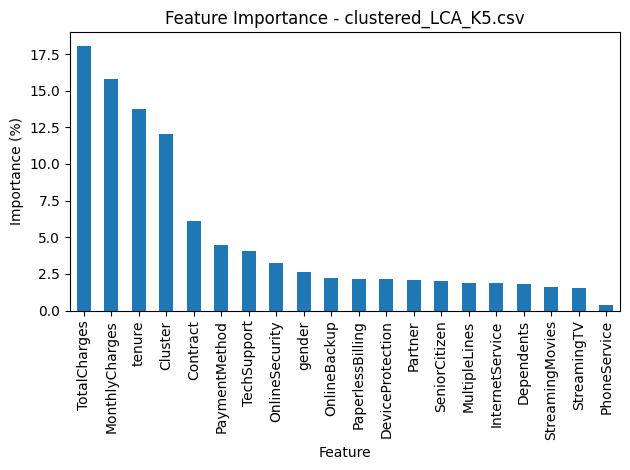


=== Results for clustered_churn_kprototype_k20.csv ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.68      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
[[953  83]
 [199 174]]

Feature Importances:
             Feature  Importance (%)
17    MonthlyCharges       16.494835
4             tenure       16.043764
18      TotalCharges       15.872263
14          Contract        7.381189
19           Cluster        5.874912
16     PaymentMethod        4.985883
8     OnlineSecurity        4.435062
11       TechSupport        4.223823
0             gender        2.763949
15  PaperlessBilling        2.603192
9       OnlineBackup        2.581824
2            Partner        2.336470
10  DeviceProtection        2.264835
7    Interne

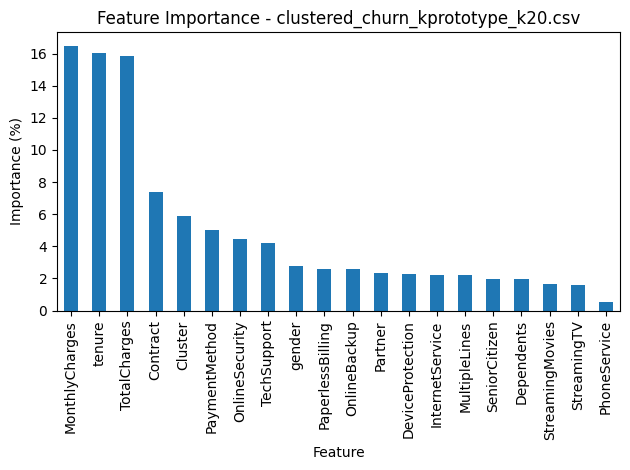


=== Results for clustered_churn_kprototype_k8.csv ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.67      0.47      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
[[950  86]
 [196 177]]

Feature Importances:
             Feature  Importance (%)
17    MonthlyCharges       16.657687
18      TotalCharges       16.305454
4             tenure       15.700615
14          Contract        7.479485
19           Cluster        6.776398
16     PaymentMethod        5.093567
11       TechSupport        3.927685
8     OnlineSecurity        3.546860
0             gender        2.762728
15  PaperlessBilling        2.576437
9       OnlineBackup        2.518709
2            Partner        2.387601
10  DeviceProtection        2.240818
6      Multip

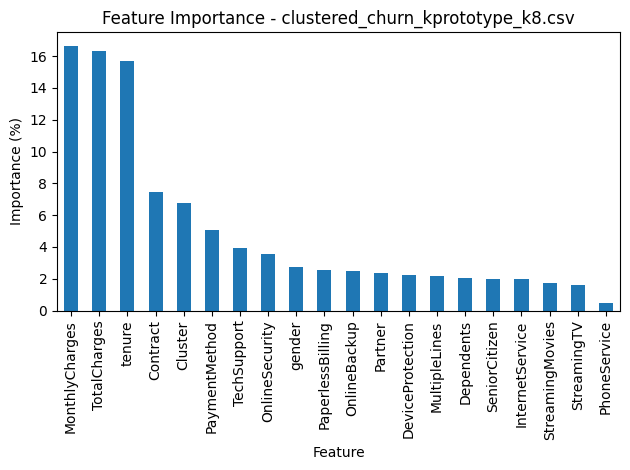


=== Results for Churn7043_clusterGAN_cluster_data_K2.csv ===

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

Confusion Matrix:
[[933 100]
 [199 175]]

Feature Importances:
             Feature  Importance (%)
18      TotalCharges       18.177245
17    MonthlyCharges       17.801542
4             tenure       14.307434
14          Contract        7.757812
16     PaymentMethod        5.084861
11       TechSupport        4.898799
8     OnlineSecurity        4.070545
7    InternetService        3.102954
0             gender        2.874677
9       OnlineBackup        2.511764
2            Partner        2.413400
15  PaperlessBilling        2.391755
10  DeviceProtection        2.339003
6     

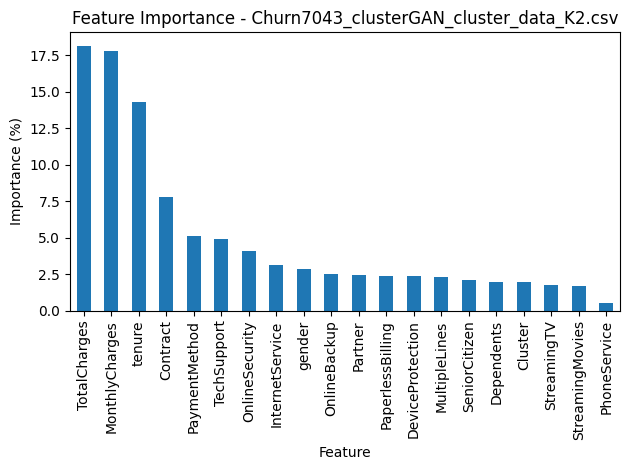


=== Results for Churn7043_clusterGAN_4clusters.csv ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409

Confusion Matrix:
[[944  92]
 [196 177]]

Feature Importances:
             Feature  Importance (%)
18      TotalCharges       18.386484
17    MonthlyCharges       17.523610
4             tenure       14.060754
14          Contract        7.345190
16     PaymentMethod        4.930056
11       TechSupport        4.304127
8     OnlineSecurity        4.259375
19           Cluster        3.218417
0             gender        2.779177
7    InternetService        2.769251
9       OnlineBackup        2.673960
15  PaperlessBilling        2.599748
2            Partner        2.411868
10  DevicePr

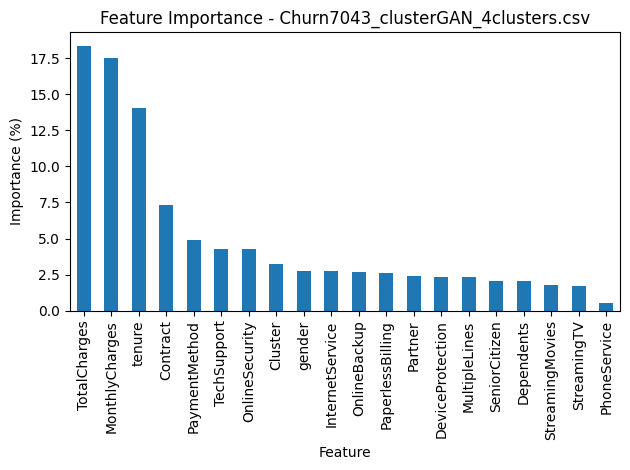


=== Results for clustered_gower_hierarchical_k4.csv ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.49      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
[[943  93]
 [190 183]]

Feature Importances:
             Feature  Importance (%)
17    MonthlyCharges       17.152735
4             tenure       16.662120
18      TotalCharges       15.871990
14          Contract        7.522402
16     PaymentMethod        5.163348
11       TechSupport        4.242442
19           Cluster        4.148526
8     OnlineSecurity        4.041782
0             gender        2.744780
7    InternetService        2.678147
15  PaperlessBilling        2.666986
9       OnlineBackup        2.642470
2            Partner        2.287269
10  DeviceP

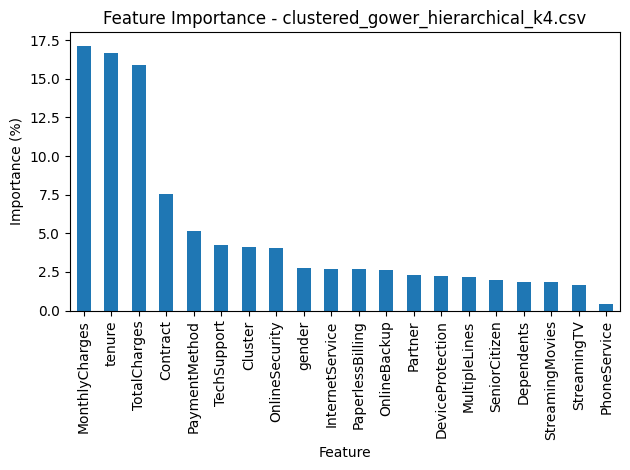


=== Results for dataset1_openml_7043x21.csv ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion Matrix:
[[932 101]
 [191 183]]

Feature Importances:
             Feature  Importance (%)
18      TotalCharges       18.495331
17    MonthlyCharges       17.801401
4             tenure       15.450965
14          Contract        8.058498
16     PaymentMethod        5.203067
8     OnlineSecurity        4.850917
11       TechSupport        4.758108
7    InternetService        2.681251
0             gender        2.671483
9       OnlineBackup        2.588264
15  PaperlessBilling        2.565162
2            Partner        2.332871
6      MultipleLines        2.261334
10  DeviceProtectio

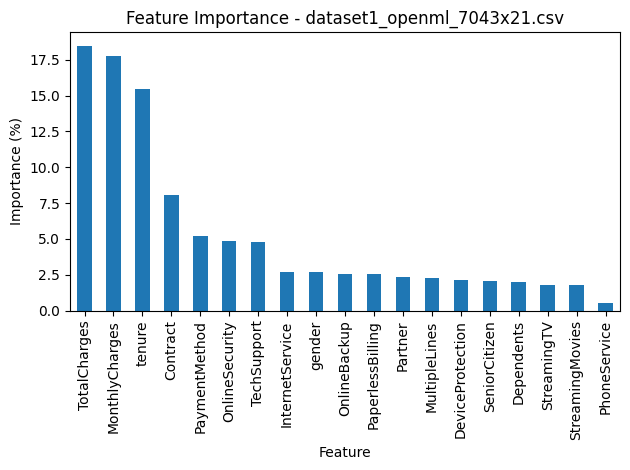

In [1]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def preprocess_data(df):
    # Drop customerID
    df = df.drop(columns=['customerID'], errors='ignore')
    
    # Clean 'TotalCharges' if it has string values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Drop rows with missing values
    df = df.dropna()

    # Label Encode categorical columns
    label_encoders = {}
    for col in df.select_dtypes(include='object').columns:
        if col != 'Churn':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le

    # Encode target
    target_encoder = LabelEncoder()
    df['Churn'] = target_encoder.fit_transform(df['Churn'])

    return df, target_encoder

def train_model(df, dataset_name):
    X = df.drop(columns=['Churn'])
    y = df['Churn']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    print(f"\n=== Results for {dataset_name} ===")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Feature Importance
    importances = rf.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance (%)': (importances / importances.sum()) * 100
    }).sort_values(by='Importance (%)', ascending=False)

    print("\nFeature Importances:")
    print(feature_importance)

    # Plot (optional)
    feature_importance.plot(x='Feature', y='Importance (%)', kind='bar', legend=False)
    plt.title(f"Feature Importance - {dataset_name}")
    plt.ylabel("Importance (%)")
    plt.tight_layout()
    plt.show()

# Folder path and separate file
folder_path = '/kaggle/input/churn-clustered-datasets'
separate_dataset_path = '/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv'

# Process all CSVs in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        full_path = os.path.join(folder_path, filename)
        df = pd.read_csv(full_path)
        df_clean, _ = preprocess_data(df)
        train_model(df_clean, filename)

# Process the separate dataset
separate_df = pd.read_csv(separate_dataset_path)
df_clean, _ = preprocess_data(separate_df)
train_model(df_clean, os.path.basename(separate_dataset_path))


#### same thing with lgbm

Scanning folder: /kaggle/input/churn-clustered-datasets

--- Processing file: clustered_LCA_K5.csv ---
→ Preprocessing dataset: clustered_LCA_K5.csv
✓ Finished preprocessing: clustered_LCA_K5.csv

=== Training LGBM model for: clustered_LCA_K5.csv ===
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.66      0.56      0.61       374

    acc

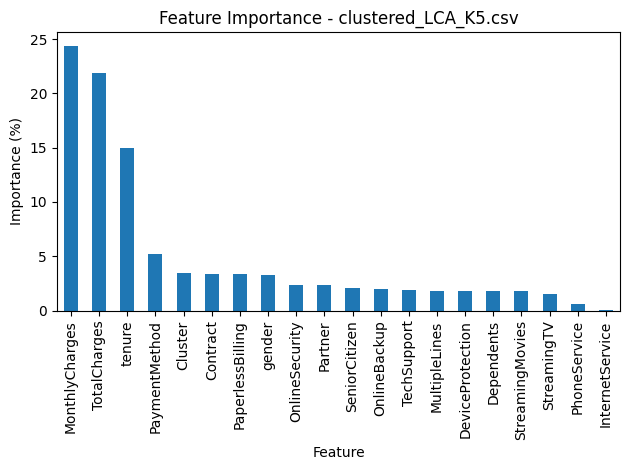

✓ Completed model training for: clustered_LCA_K5.csv

--- Processing file: clustered_churn_kprototype_k20.csv ---
→ Preprocessing dataset: clustered_churn_kprototype_k20.csv
✓ Finished preprocessing: clustered_churn_kprototype_k20.csv

=== Training LGBM model for: clustered_churn_kprototype_k20.csv ===
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
         

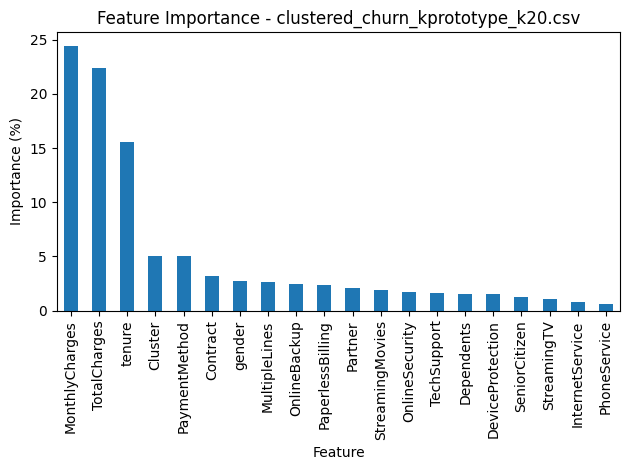

✓ Completed model training for: clustered_churn_kprototype_k20.csv

--- Processing file: clustered_churn_kprototype_k8.csv ---
→ Preprocessing dataset: clustered_churn_kprototype_k8.csv
✓ Finished preprocessing: clustered_churn_kprototype_k8.csv

=== Training LGBM model for: clustered_churn_kprototype_k8.csv ===
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036

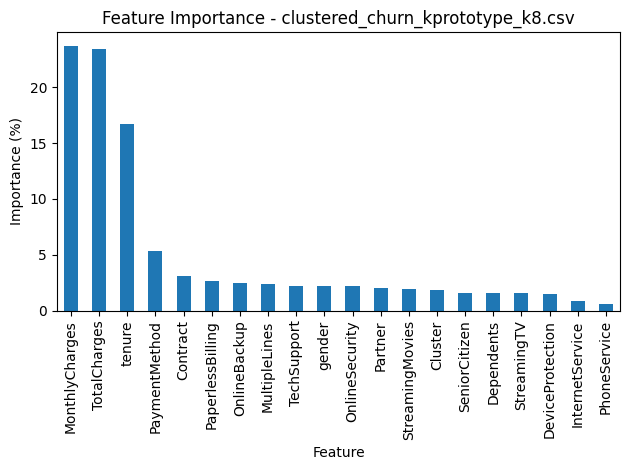

✓ Completed model training for: clustered_churn_kprototype_k8.csv

--- Processing file: Churn7043_clusterGAN_cluster_data_K2.csv ---
→ Preprocessing dataset: Churn7043_clusterGAN_cluster_data_K2.csv
✓ Finished preprocessing: Churn7043_clusterGAN_cluster_data_K2.csv

=== Training LGBM model for: Churn7043_clusterGAN_cluster_data_K2.csv ===
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151

Classification Report:
              precision    recall  f1-score   support

           0       0.83   

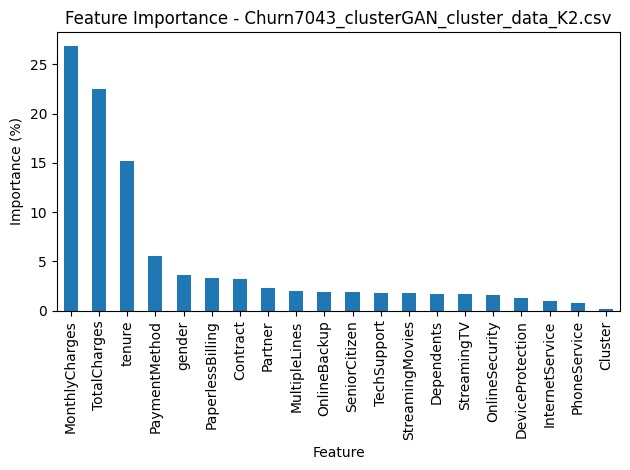

✓ Completed model training for: Churn7043_clusterGAN_cluster_data_K2.csv

--- Processing file: Churn7043_clusterGAN_4clusters.csv ---
→ Preprocessing dataset: Churn7043_clusterGAN_4clusters.csv
✓ Finished preprocessing: Churn7043_clusterGAN_4clusters.csv

=== Training LGBM model for: Churn7043_clusterGAN_4clusters.csv ===
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87

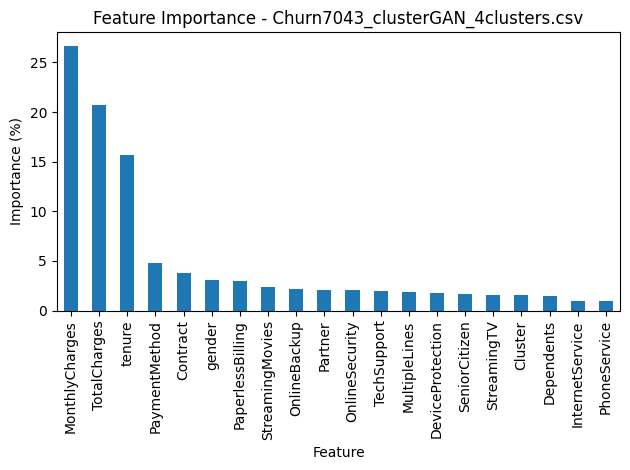

✓ Completed model training for: Churn7043_clusterGAN_4clusters.csv

--- Processing file: clustered_gower_hierarchical_k4.csv ---
→ Preprocessing dataset: clustered_gower_hierarchical_k4.csv
✓ Finished preprocessing: clustered_gower_hierarchical_k4.csv

=== Training LGBM model for: clustered_gower_hierarchical_k4.csv ===
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88  

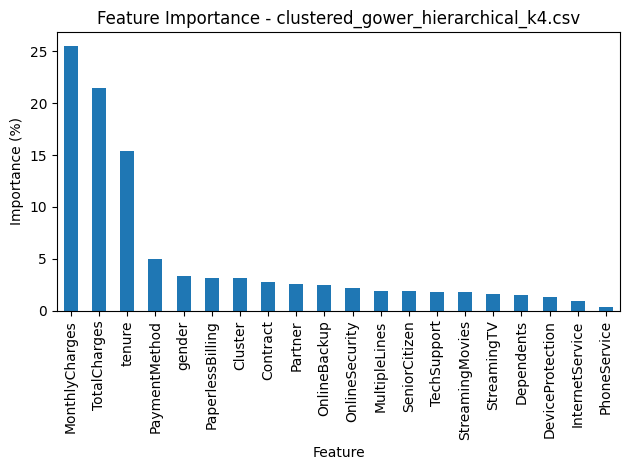

✓ Completed model training for: clustered_gower_hierarchical_k4.csv

--- Processing separate dataset: dataset1_openml_7043x21.csv ---
→ Preprocessing dataset: dataset1_openml_7043x21.csv
✓ Finished preprocessing: dataset1_openml_7043x21.csv

=== Training LGBM model for: dataset1_openml_7043x21.csv ===
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1033
          

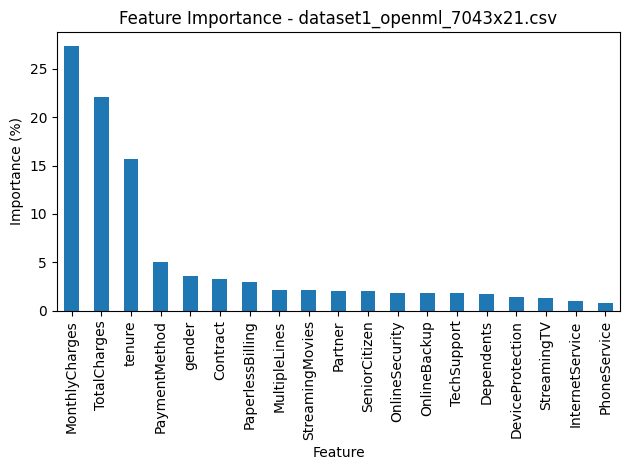

✓ Completed model training for: dataset1_openml_7043x21.csv


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

def preprocess_data(df, dataset_name):
    print(f"→ Preprocessing dataset: {dataset_name}")
    
    # Drop customerID
    df = df.drop(columns=['customerID'], errors='ignore')
    
    # Clean 'TotalCharges'
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Drop rows with missing values
    df = df.dropna()

    # Label Encode categorical columns
    label_encoders = {}
    for col in df.select_dtypes(include='object').columns:
        if col != 'Churn':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le

    # Encode target
    target_encoder = LabelEncoder()
    df['Churn'] = target_encoder.fit_transform(df['Churn'])

    print(f"✓ Finished preprocessing: {dataset_name}")
    return df, target_encoder

def train_model(df, dataset_name):
    print(f"\n=== Training LGBM model for: {dataset_name} ===")

    X = df.drop(columns=['Churn'])
    y = df['Churn']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Feature Importance
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance (%)': (importances / importances.sum()) * 100
    }).sort_values(by='Importance (%)', ascending=False)

    print("\nFeature Importances:")
    print(feature_importance)

    # Plot feature importance
    feature_importance.plot(x='Feature', y='Importance (%)', kind='bar', legend=False)
    plt.title(f"Feature Importance - {dataset_name}")
    plt.ylabel("Importance (%)")
    plt.tight_layout()
    plt.show()

    print(f"✓ Completed model training for: {dataset_name}")

# Folder path and separate file
folder_path = '/kaggle/input/churn-clustered-datasets'  # Update this
separate_dataset_path = '/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv'  # Update this

# Process all CSVs in the folder
print(f"Scanning folder: {folder_path}")
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        print(f"\n--- Processing file: {filename} ---")
        full_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(full_path)
            df_clean, _ = preprocess_data(df, filename)
            train_model(df_clean, filename)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

# Process the separate dataset
print(f"\n--- Processing separate dataset: {os.path.basename(separate_dataset_path)} ---")
try:
    separate_df = pd.read_csv(separate_dataset_path)
    df_clean, _ = preprocess_data(separate_df, os.path.basename(separate_dataset_path))
    train_model(df_clean, os.path.basename(separate_dataset_path))
except Exception as e:
    print(f"❌ Error processing separate dataset: {e}")


### baseline (optimisitic), my reference : (max point till where both the precision and recall can be increased-- beyond this point raising one will decrease another)

→ Preprocessing data...
✓ Preprocessing complete.
→ Upsampling: 'Churn=0' to 1.5x and 'Churn=1' to 4x...
✓ Upsampled dataset with 12938 total samples.
Churn
0    6582
1    6356
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 6356, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 12938, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491266 -> initscore=-0.034939
[LightGBM] [Info] Start training from score -0.034939

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80       775
           1       0.50      0.78      0.61       280

    accuracy                           0.73      1055


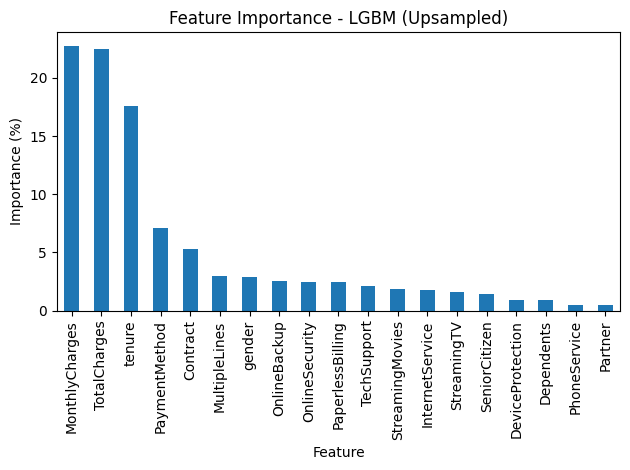

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# === Preprocessing function ===
def preprocess_data(df):
    print("→ Preprocessing data...")

    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()

    # Label encode categorical columns (excluding Churn)
    for col in df.select_dtypes(include='object').columns:
        if col != 'Churn':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    # Explicit mapping for Churn: 'Yes' -> 1, 'No' -> 0
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    print("✓ Preprocessing complete.")
    return df

# === Updated Balancing Function ===
def upsample_classes(df):
    print("→ Upsampling: 'Churn=0' to 1.5x and 'Churn=1' to 4x...")

    class_0 = df[df['Churn'] == 0]
    class_1 = df[df['Churn'] == 1]

    class_0_upsampled = class_0.sample(n=int(len(class_0) * 1.5), replace=True, random_state=42)
    class_1_upsampled = class_1.sample(n=int(len(class_1) * 4.0), replace=True, random_state=42)

    df_upsampled = pd.concat([class_0_upsampled, class_1_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"✓ Upsampled dataset with {len(df_upsampled)} total samples.")
    print(df_upsampled['Churn'].value_counts())
    return df_upsampled

# === Training and evaluation ===
def train_lgbm_model(df_train, df_test, params):
    X_train = df_train.drop(columns=['Churn'])
    y_train = df_train['Churn']

    X_test = df_test.drop(columns=['Churn'])
    y_test = df_test['Churn']

    model = LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Feature importance
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance (%)': (importances / importances.sum()) * 100
    }).sort_values(by='Importance (%)', ascending=False)

    print("\nFeature Importances:")
    print(feature_importance)

    # Plot
    feature_importance.plot(x='Feature', y='Importance (%)', kind='bar', legend=False)
    plt.title("Feature Importance - LGBM (Upsampled)")
    plt.ylabel("Importance (%)")
    plt.tight_layout()
    plt.show()

# === Load and preprocess ===
separate_dataset_path = '/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv'
df = pd.read_csv(separate_dataset_path)
df_clean = preprocess_data(df)

# === Hold out 15% for evaluation ===
df_main, df_holdout = train_test_split(df_clean, test_size=0.15, random_state=42, stratify=df_clean['Churn'])

# === Upsample classes ===
df_balanced = upsample_classes(df_main)

# === LightGBM parameters ===
lgbm_params = {
    'num_leaves': 10,
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_samples': 20,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

# === Train and evaluate ===
train_lgbm_model(df_balanced, df_holdout, lgbm_params)


### with upsampling the entire dataset first (misleading but just kept for future reference)

→ Preprocessing data...
✓ Preprocessing complete.
→ Upsampling: 'Churn=0' to 1.5x and 'Churn=1' to 4x...
✓ Upsampled & shuffled dataset with 15220 total samples.
Churn
0    7744
1    7476
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 6355, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 12937, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491227 -> initscore=-0.035097
[LightGBM] [Info] Start training from score -0.035097

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1162
           1       0.78      0.83      0.80      1121

    accuracy                           0.

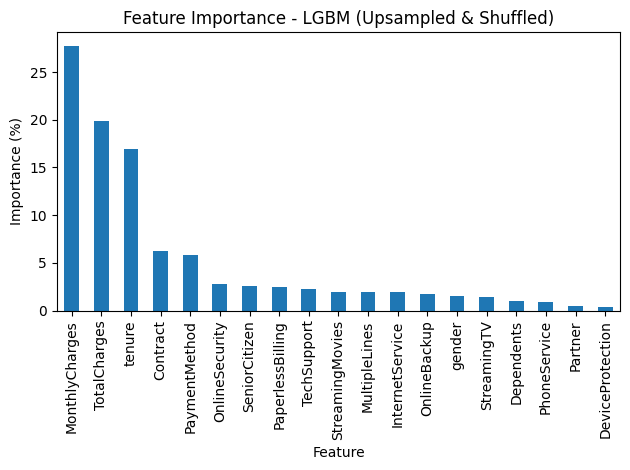

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# === Preprocessing function ===
def preprocess_data(df):
    print("→ Preprocessing data...")

    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()

    # Label encode categorical columns (excluding Churn)
    for col in df.select_dtypes(include='object').columns:
        if col != 'Churn':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    # Explicit mapping for Churn: 'Yes' -> 1, 'No' -> 0
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    print("✓ Preprocessing complete.")
    return df

# === Updated Balancing Function ===
def upsample_and_shuffle(df):
    print("→ Upsampling: 'Churn=0' to 1.5x and 'Churn=1' to 4x...")

    class_0 = df[df['Churn'] == 0]
    class_1 = df[df['Churn'] == 1]

    class_0_upsampled = class_0.sample(n=int(len(class_0) * 1.5), replace=True, random_state=42)
    class_1_upsampled = class_1.sample(n=int(len(class_1) * 4.0), replace=True, random_state=42)

    df_upsampled = pd.concat([class_0_upsampled, class_1_upsampled], axis=0)

    # 🚨 Thorough shuffle after upsampling and before splitting
    df_upsampled = df_upsampled.sample(frac=1.0, random_state=99).reset_index(drop=True)

    print(f"✓ Upsampled & shuffled dataset with {len(df_upsampled)} total samples.")
    print(df_upsampled['Churn'].value_counts())
    return df_upsampled

# === Training and evaluation ===
def train_lgbm_model(df_train, df_test, params):
    X_train = df_train.drop(columns=['Churn'])
    y_train = df_train['Churn']

    X_test = df_test.drop(columns=['Churn'])
    y_test = df_test['Churn']

    model = LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    print("🧾 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Feature importance
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance (%)': (importances / importances.sum()) * 100
    }).sort_values(by='Importance (%)', ascending=False)

    print("\n🔥 Feature Importances:")
    print(feature_importance)

    # Plot
    feature_importance.plot(x='Feature', y='Importance (%)', kind='bar', legend=False)
    plt.title("Feature Importance - LGBM (Upsampled & Shuffled)")
    plt.ylabel("Importance (%)")
    plt.tight_layout()
    plt.show()

# === Load and preprocess ===
separate_dataset_path = '/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv'
df = pd.read_csv(separate_dataset_path)
df_clean = preprocess_data(df)

# === Upsample first, then shuffle and split ===
df_balanced = upsample_and_shuffle(df_clean)

# === Split AFTER shuffling to avoid test leakage ===
df_train, df_test = train_test_split(df_balanced, test_size=0.15, stratify=df_balanced['Churn'], random_state=42)

# === LightGBM parameters ===
lgbm_params = {
    'num_leaves': 10,
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_samples': 20,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

# === Train and evaluate ===
train_lgbm_model(df_train, df_test, lgbm_params)


In [15]:
# === Count unique rows in train and test sets ===
num_unique_train = df_train.drop_duplicates().shape[0]
num_unique_test = df_test.drop_duplicates().shape[0]

print(f"✅ Unique samples in training set: {num_unique_train}")
print(f"✅ Unique samples in test set: {num_unique_test}")


✅ Unique samples in training set: 5497
✅ Unique samples in test set: 1876


→ Preprocessing data...
✓ Preprocessing complete.
→ Creating dataset with 7500 'No' and 75000 'Yes' samples (with replacement if needed)...
⚠️ Class 0 has only 4388 samples — oversampling to get 7500
⚠️ Class 1 has only 1589 samples — oversampling to get 75000
✓ Final dataset has exactly 7500 'No' and 75000 'Yes' samples. Total: 82500
[LightGBM] [Info] Number of positive: 75000, number of negative: 7500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 82500, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909091 -> initscore=2.302585
[LightGBM] [Info] Start training from score 2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

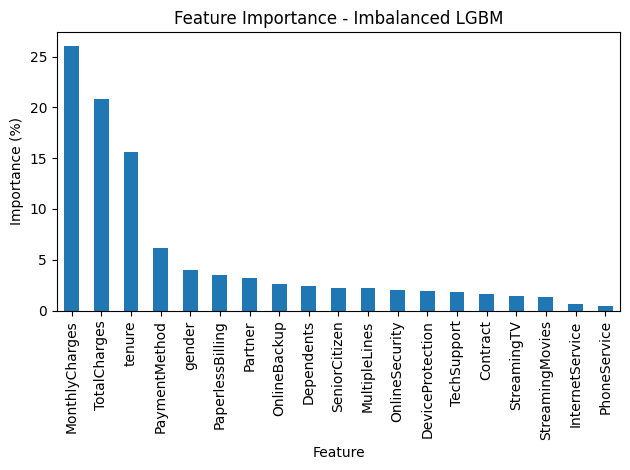

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# === Preprocessing function ===
def preprocess_data(df):
    print("→ Preprocessing data...")

    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()

    for col in df.select_dtypes(include='object').columns:
        if col != 'Churn':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    # Explicit mapping
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    print("✓ Preprocessing complete.")
    return df

# === Strict custom imbalance function ===
def custom_imbalance(df, target_col='Churn', n_class0=18000, n_class1=18000):
    print(f"→ Creating dataset with {n_class0} 'No' and {n_class1} 'Yes' samples (with replacement if needed)...")

    class_0 = df[df[target_col] == 0]
    class_1 = df[df[target_col] == 1]

    # Determine if replacement is needed
    replace_0 = len(class_0) < n_class0
    replace_1 = len(class_1) < n_class1

    if replace_0:
        print(f"⚠️ Class 0 has only {len(class_0)} samples — oversampling to get {n_class0}")
    if replace_1:
        print(f"⚠️ Class 1 has only {len(class_1)} samples — oversampling to get {n_class1}")

    class_0_sampled = class_0.sample(n_class0, replace=replace_0, random_state=42)
    class_1_sampled = class_1.sample(n_class1, replace=replace_1, random_state=42)

    df_imbalanced = pd.concat([class_0_sampled, class_1_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"✓ Final dataset has exactly {n_class0} 'No' and {n_class1} 'Yes' samples. Total: {len(df_imbalanced)}")
    return df_imbalanced

# === Training and evaluation ===
def train_lgbm_model(df_train, df_test, params):
    X_train = df_train.drop(columns=['Churn'])
    y_train = df_train['Churn']

    X_test = df_test.drop(columns=['Churn'])
    y_test = df_test['Churn']

    model = LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance (%)': (importances / importances.sum()) * 100
    }).sort_values(by='Importance (%)', ascending=False)

    print("\nFeature Importances:")
    print(feature_importance)

    feature_importance.plot(x='Feature', y='Importance (%)', kind='bar', legend=False)
    plt.title("Feature Importance - Imbalanced LGBM")
    plt.ylabel("Importance (%)")
    plt.tight_layout()
    plt.show()

# === Load and preprocess ===
separate_dataset_path = '/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv'
df = pd.read_csv(separate_dataset_path)
df_clean = preprocess_data(df)

# === Hold out 15% of data ===
df_main, df_holdout = train_test_split(df_clean, test_size=0.15, random_state=42, stratify=df_clean['Churn'])

# === Create imbalanced training set ===
# 🔁 You can change n_class0 and n_class1 here
df_custom = custom_imbalance(df_main, target_col='Churn', n_class0=7500, n_class1=75000)

# === LGBM parameters ===
lgbm_params = {
    'num_leaves': 100,
    'max_depth': 15,
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'min_child_samples': 20,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

# === Train and evaluate ===
train_lgbm_model(df_custom, df_holdout, lgbm_params)


In [ ]:
Classification Report:( n_class0=35000, n_class1=250000)
              precision    recall  f1-score   support

           0       0.89      0.63      0.74       775
           1       0.43      0.78      0.56       280

    accuracy                           0.67      1055
   macro avg       0.66      0.71      0.65      1055
weighted avg       0.77      0.67      0.69      1055

Classification Report: (n_class0=35000, n_class1=80000)
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       775
           1       0.48      0.73      0.58       280

    accuracy                           0.72      1055
   macro avg       0.68      0.72      0.68      1055
weighted avg       0.77      0.72      0.73      1055

Classification Report: (n_class0=35000, n_class1=80000)
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       775
           1       0.48      0.73      0.58       280

    accuracy                           0.72      1055
   macro avg       0.68      0.72      0.68      1055
weighted avg       0.77      0.72      0.73      1055


Classification Report:  (n_class0=35000, n_class1=150000)
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       775
           1       0.45      0.77      0.57       280

    accuracy                           0.69      1055
   macro avg       0.67      0.71      0.66      1055
weighted avg       0.77      0.69      0.71      1055


Classification Report:  (n_class0=60000, n_class1=150000)
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       775
           1       0.49      0.75      0.59       280

    accuracy                           0.72      1055
   macro avg       0.69      0.73      0.69      1055
weighted avg       0.78      0.72      0.74      1055


Classification Report:  (n_class0=200000, n_class1=150000)
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       775
           1       0.53      0.61      0.57       280

    accuracy                           0.76      1055
   macro avg       0.69      0.71      0.70      1055
weighted avg       0.77      0.76      0.76      1055

Classification Report: (n_class0=400000, n_class1=150000)
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       775
           1       0.59      0.52      0.55       280

    accuracy                           0.78      1055
   macro avg       0.71      0.69      0.70      1055
weighted avg       0.77      0.78      0.77      1055

### Using decision tree(no class imbalance handling)

→ Preprocessing data...
✓ Preprocessing complete.

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       517
           1       0.53      0.49      0.51       187

    accuracy                           0.75       704
   macro avg       0.67      0.67      0.67       704
weighted avg       0.74      0.75      0.74       704

Confusion Matrix:
[[434  83]
 [ 95  92]]

Feature Importances:
             Feature  Importance (%)
14          Contract       32.069975
18      TotalCharges       14.707582
17    MonthlyCharges       13.684478
4             tenure       11.112926
8     OnlineSecurity        8.781208
7    InternetService        5.427660
16     PaymentMethod        2.434765
2            Partner        1.392895
9       OnlineBackup        1.331947
3         Dependents        1.285826
6      MultipleLines        1.265773
1      SeniorCitizen        1.193383
0             gender        1.030827
11       TechSuppo

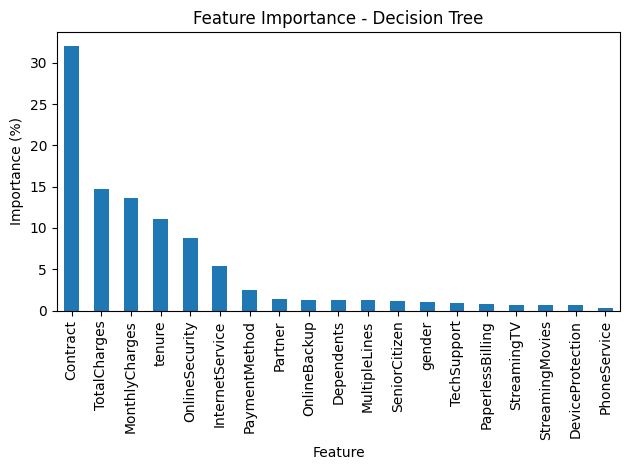

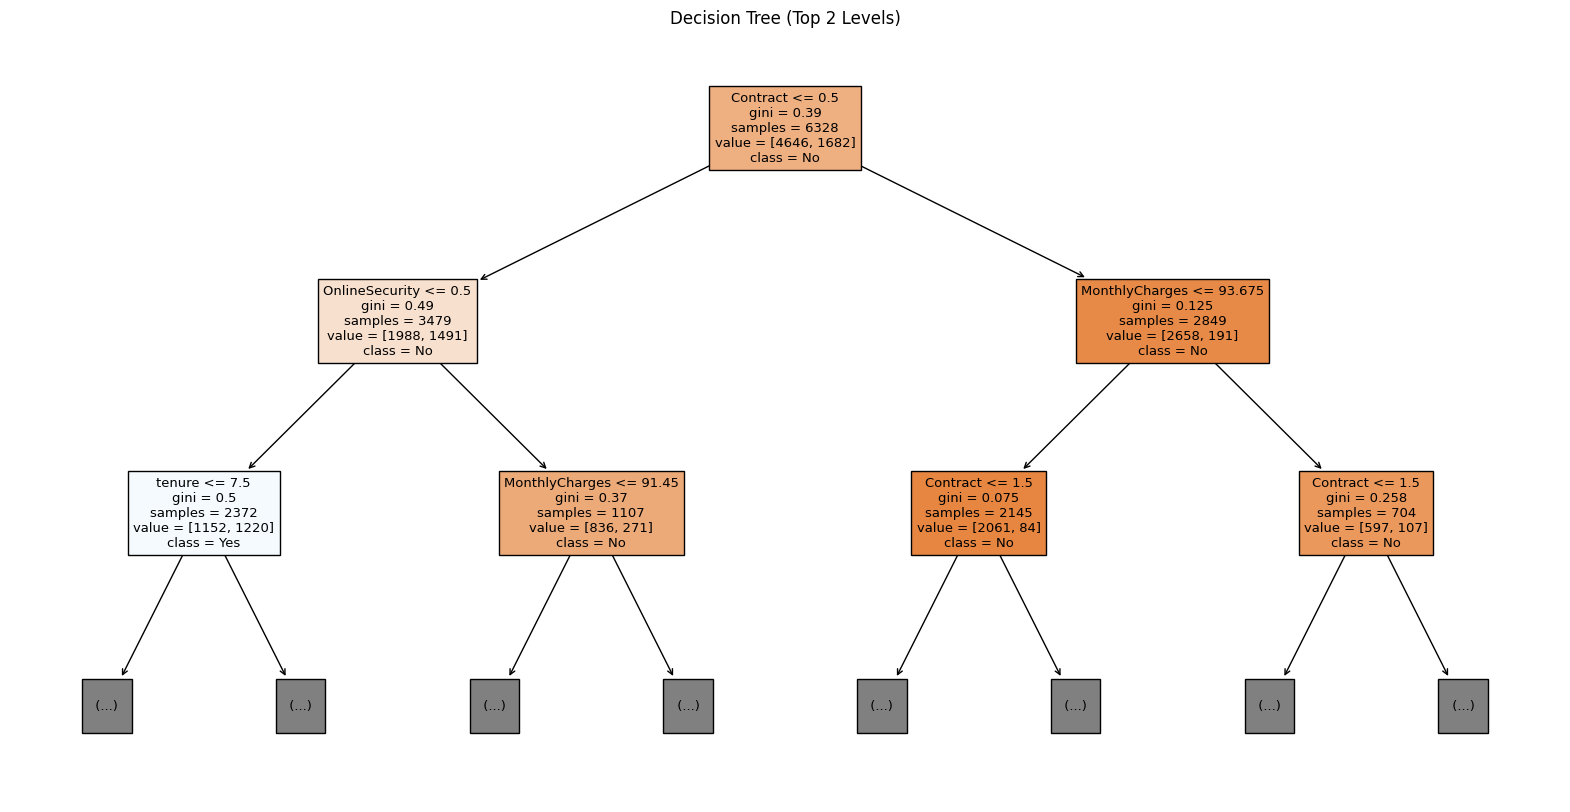

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# === Preprocessing function ===
def preprocess_data(df):
    print("→ Preprocessing data...")

    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()

    for col in df.select_dtypes(include='object').columns:
        if col != 'Churn':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    print("✓ Preprocessing complete.")
    return df

# === Training and evaluation using Decision Tree ===
def train_decision_tree(df_train, df_test, max_depth=None):
    X_train = df_train.drop(columns=['Churn'])
    y_train = df_train['Churn']

    X_test = df_test.drop(columns=['Churn'])
    y_test = df_test['Churn']

    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Plot feature importance
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance (%)': (importances / importances.sum()) * 100
    }).sort_values(by='Importance (%)', ascending=False)

    print("\nFeature Importances:")
    print(feature_importance)

    feature_importance.plot(x='Feature', y='Importance (%)', kind='bar', legend=False)
    plt.title("Feature Importance - Decision Tree")
    plt.ylabel("Importance (%)")
    plt.tight_layout()
    plt.show()

    # Optional: Plot tree structure
    plt.figure(figsize=(20, 10))
    plot_tree(model, feature_names=X_train.columns, class_names=["No", "Yes"], filled=True, max_depth=2)
    plt.title("Decision Tree (Top 2 Levels)")
    plt.show()

# === Load and preprocess ===
separate_dataset_path = '/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv'
df = pd.read_csv(separate_dataset_path)
df_clean = preprocess_data(df)

# === Split: 90% train / 10% test ===
df_main, df_holdout = train_test_split(df_clean, test_size=0.10, random_state=42, stratify=df_clean['Churn'])

# === Train and evaluate on original data ===
train_decision_tree(df_main, df_holdout, max_depth=10)  # Adjust depth if needed


### Neural network based

2025-05-13 17:42:39.438694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747158159.681185      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747158159.745296      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


→ Preprocessing data...
✓ Preprocessing complete.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-13 17:42:54.099344: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6681 - loss: 0.5831 - val_accuracy: 0.7970 - val_loss: 0.4315
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.4398 - val_accuracy: 0.7978 - val_loss: 0.4250
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7933 - loss: 0.4435 - val_accuracy: 0.7954 - val_loss: 0.4254
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.4130 - val_accuracy: 0.7986 - val_loss: 0.4233
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8086 - loss: 0.4186 - val_accuracy: 0.7970 - val_loss: 0.4239
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8112 - loss: 0.4130 - val_accuracy: 0.8033 - val_loss: 0.4225
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8060 - loss: 0.4152 - val_accuracy: 0.7970 - val_loss: 0.4211
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.4067 - val_accu

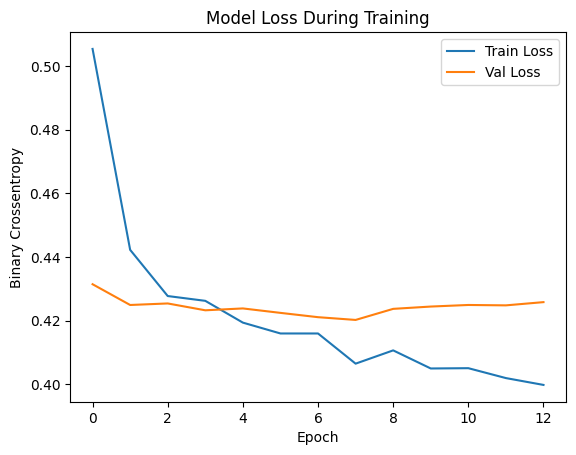

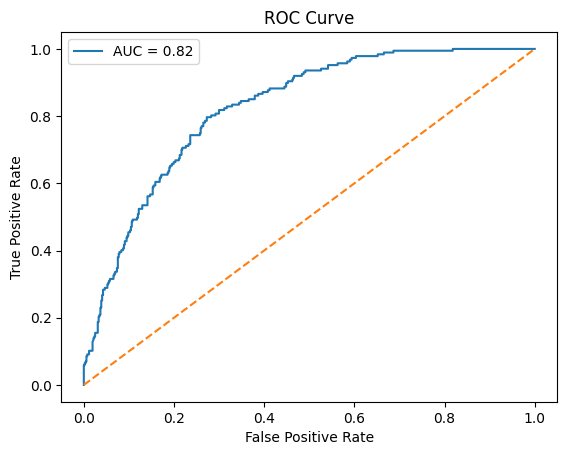

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === Load dataset ===
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

# === Preprocessing ===
def preprocess_data(df):
    print("→ Preprocessing data...")

    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()

    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    # Feature engineering
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])

    # One-hot encode categorical features
    df = pd.get_dummies(df, drop_first=True)

    print("✓ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Split: 90% train / 10% test ===
df_main, df_holdout = train_test_split(df_clean, test_size=0.10, random_state=42, stratify=df_clean['Churn'])

X_train = df_main.drop('Churn', axis=1)
y_train = df_main['Churn']
X_test = df_holdout.drop('Churn', axis=1)
y_test = df_holdout['Churn']

# === Normalize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Build the neural network ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Train the model ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# === Plot training history ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.show()

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


→ Preprocessing data...
✓ Preprocessing complete.
Train class distribution:
Churn
0    4646
1    1682
Name: count, dtype: int64
Test class distribution:
Churn
0    517
1    187
Name: count, dtype: int64

Minority samples (Churn=1): 1682
Majority samples (Churn=0): 4646
Creating 3 batches

🔁 Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔁 Epoch 2/100

🔁 Epoch 3/100

🔁 Epoch 4/100

🔁 Epoch 5/100

🔁 Epoch 6/100

🔁 Epoch 7/100

🔁 Epoch 8/100

🔁 Epoch 9/100

🔁 Epoch 10/100

🔁 Epoch 11/100

🔁 Epoch 12/100

🔁 Epoch 13/100

🔁 Epoch 14/100

🔁 Epoch 15/100

🔁 Epoch 16/100

🔁 Epoch 17/100

🔁 Epoch 18/100

🔁 Epoch 19/100

🔁 Epoch 20/100

🔁 Epoch 21/100

🔁 Epoch 22/100

🔁 Epoch 23/100

🔁 Epoch 24/100

🔁 Epoch 25/100

🔁 Epoch 26/100

🔁 Epoch 27/100

🔁 Epoch 28/100

🔁 Epoch 29/100

🔁 Epoch 30/100

🔁 Epoch 31/100

🔁 Epoch 32/100

🔁 Epoch 33/100

🔁 Epoch 34/100

🔁 Epoch 35/100

🔁 Epoch 36/100

🔁 Epoch 37/100

🔁 Epoch 38/100

🔁 Epoch 39/100

🔁 Epoch 40/100

🔁 Epoch 41/100

🔁 Epoch 42/100

🔁 Epoch 43/100

🔁 Epoch 44/100

🔁 Epoch 45/100

🔁 Epoch 46/100

🔁 Epoch 47/100

🔁 Epoch 48/100

🔁 Epoch 49/100

🔁 Epoch 50/100

🔁 Epoch 51/100

🔁 Epoch 52/100

🔁 Epoch 53/100

🔁 Epoch 54/100

🔁 Epoch 55/100

🔁 Epoch 56/100

🔁 Epoch 57/100

🔁 Epoch 58/100

🔁 Epoch 59/100

🔁 Epoch 60/100

🔁 Epoch 61/100

🔁 Epoch 62/100

🔁 Epoch 63/100

🔁 Epoch 64/100


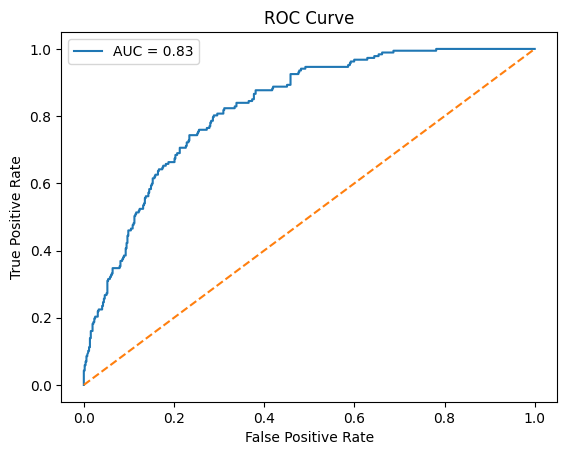

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# === Load and preprocess ===
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("→ Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✓ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Stratified split: 90% train / 10% test ===
df_train, df_test = train_test_split(df_clean, test_size=0.10, random_state=42, stratify=df_clean['Churn'])

# === Count 'Yes' (1) and 'No' (0) ===
print("Train class distribution:")
print(df_train['Churn'].value_counts())
print("Test class distribution:")
print(df_test['Churn'].value_counts())

# === Separate minority class ('Yes') ===
minority_df = df_train[df_train['Churn'] == 1]
majority_df = df_train[df_train['Churn'] == 0]

minority_count = len(minority_df)
majority_count = len(majority_df)
num_batches = int(np.ceil(majority_count / minority_count))

print(f"\nMinority samples (Churn=1): {minority_count}")
print(f"Majority samples (Churn=0): {majority_count}")
print(f"Creating {num_batches} batches")

# === Create model ===
input_dim = df_train.shape[1] - 1  # exclude 'Churn'
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Prepare scaler ===
scaler = StandardScaler()
scaler.fit(df_train.drop('Churn', axis=1))

# === Convert test data ===
X_test = scaler.transform(df_test.drop('Churn', axis=1))
y_test = df_test['Churn'].values

# === Custom balanced batch training ===
for epoch in range(100):
    print(f"\n🔁 Epoch {epoch+1}/100")

    # Shuffle majority samples each epoch
    majority_shuffled = majority_df.sample(frac=1, random_state=epoch)

    for i in range(num_batches):
        batch_majority = majority_shuffled.iloc[i*minority_count : (i+1)*minority_count]
        batch = pd.concat([batch_majority, minority_df])

        # Shuffle the batch
        batch = batch.sample(frac=1, random_state=epoch + i)

        # Prepare batch data
        X_batch = scaler.transform(batch.drop('Churn', axis=1))
        y_batch = batch['Churn'].values

        # Train on this batch
        model.train_on_batch(X_batch, y_batch)

# === Evaluation ===
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### same nn arch but Implements custom balanced batch training so that every update sees equal churn vs non-churn samples.

→ Preprocessing data...
✓ Preprocessing complete.
Train class distribution:
Churn
0    4905
1    1775
Name: count, dtype: int64
Test class distribution:
Churn
0    258
1     94
Name: count, dtype: int64

Minority samples (Churn=1): 1775
Majority samples (Churn=0): 4905
Creating 3 batches

🔁 Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔁 Epoch 2/100

🔁 Epoch 3/100

🔁 Epoch 4/100

🔁 Epoch 5/100

🔁 Epoch 6/100

🔁 Epoch 7/100

🔁 Epoch 8/100

🔁 Epoch 9/100

🔁 Epoch 10/100

🔁 Epoch 11/100

🔁 Epoch 12/100

🔁 Epoch 13/100

🔁 Epoch 14/100

🔁 Epoch 15/100

🔁 Epoch 16/100

🔁 Epoch 17/100

🔁 Epoch 18/100

🔁 Epoch 19/100

🔁 Epoch 20/100

🔁 Epoch 21/100

🔁 Epoch 22/100

🔁 Epoch 23/100

🔁 Epoch 24/100

🔁 Epoch 25/100

🔁 Epoch 26/100

🔁 Epoch 27/100

🔁 Epoch 28/100

🔁 Epoch 29/100

🔁 Epoch 30/100

🔁 Epoch 31/100

🔁 Epoch 32/100

🔁 Epoch 33/100

🔁 Epoch 34/100

🔁 Epoch 35/100

🔁 Epoch 36/100

🔁 Epoch 37/100

🔁 Epoch 38/100

🔁 Epoch 39/100

🔁 Epoch 40/100

🔁 Epoch 41/100

🔁 Epoch 42/100

🔁 Epoch 43/100

🔁 Epoch 44/100

🔁 Epoch 45/100

🔁 Epoch 46/100

🔁 Epoch 47/100

🔁 Epoch 48/100

🔁 Epoch 49/100

🔁 Epoch 50/100

🔁 Epoch 51/100

🔁 Epoch 52/100

🔁 Epoch 53/100

🔁 Epoch 54/100

🔁 Epoch 55/100

🔁 Epoch 56/100

🔁 Epoch 57/100

🔁 Epoch 58/100

🔁 Epoch 59/100

🔁 Epoch 60/100

🔁 Epoch 61/100

🔁 Epoch 62/100

🔁 Epoch 63/100

🔁 Epoch 64/100


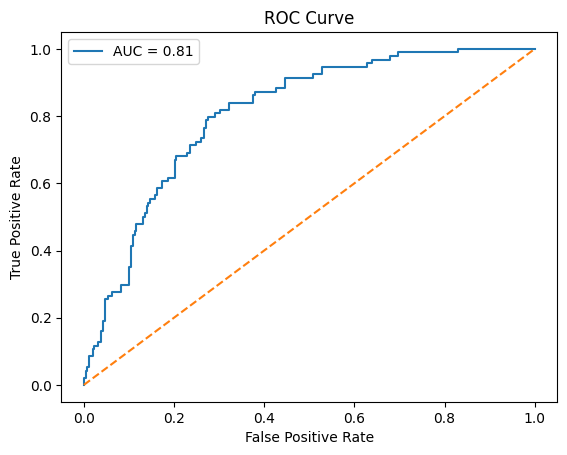

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# === Load and preprocess ===
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("→ Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✓ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Stratified split: 90% train / 10% test ===
# NEW:
df_train, df_test = train_test_split(df_clean, test_size=0.05, random_state=42, stratify=df_clean['Churn'])

# === Count 'Yes' (1) and 'No' (0) ===
print("Train class distribution:")
print(df_train['Churn'].value_counts())
print("Test class distribution:")
print(df_test['Churn'].value_counts())

# === Separate minority class ('Yes') ===
minority_df = df_train[df_train['Churn'] == 1]
majority_df = df_train[df_train['Churn'] == 0]

minority_count = len(minority_df)
majority_count = len(majority_df)
num_batches = int(np.ceil(majority_count / minority_count))

print(f"\nMinority samples (Churn=1): {minority_count}")
print(f"Majority samples (Churn=0): {majority_count}")
print(f"Creating {num_batches} batches")

# === Create model ===
input_dim = df_train.shape[1] - 1  # exclude 'Churn'
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Prepare scaler ===
scaler = StandardScaler()
scaler.fit(df_train.drop('Churn', axis=1))

# === Convert test data ===
X_test = scaler.transform(df_test.drop('Churn', axis=1))
y_test = df_test['Churn'].values

# === Custom balanced batch training ===
for epoch in range(100):
    print(f"\n🔁 Epoch {epoch+1}/100")

    # Shuffle majority samples each epoch
    majority_shuffled = majority_df.sample(frac=1, random_state=epoch)

    for i in range(num_batches):
        batch_majority = majority_shuffled.iloc[i*minority_count : (i+1)*minority_count]
        batch = pd.concat([batch_majority, minority_df])

        # Shuffle the batch
        batch = batch.sample(frac=1, random_state=epoch + i)

        # Prepare batch data
        X_batch = scaler.transform(batch.drop('Churn', axis=1))
        y_batch = batch['Churn'].values

        # Train on this batch
        model.train_on_batch(X_batch, y_batch)

# === Evaluation ===
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### This script → Curriculum training:

First trains only on the majority class.

Then gradually introduces minority samples in increasing numbers.

Aims to make the network less biased toward the majority while not destabilizing training.

2025-05-14 10:54:28.699111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747220068.966062      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747220069.040483      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


→ Preprocessing data...
✓ Preprocessing complete.

📘 Phase 1: Training on majority class only
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-14 10:54:44.632740: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10

📗 Phase 2: Introducing minority samples in stages

🔁 Training with 100 minority samples + 4646 majority samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10

🔁 Training with 200 minority samples + 4646 majority samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10

🔁 Training with 300 minority samples + 4646 majority samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10

🔁 Training with 400 minority samples + 4646 majority samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10

🔁 Training with 500 minority samples + 4646 majority samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9

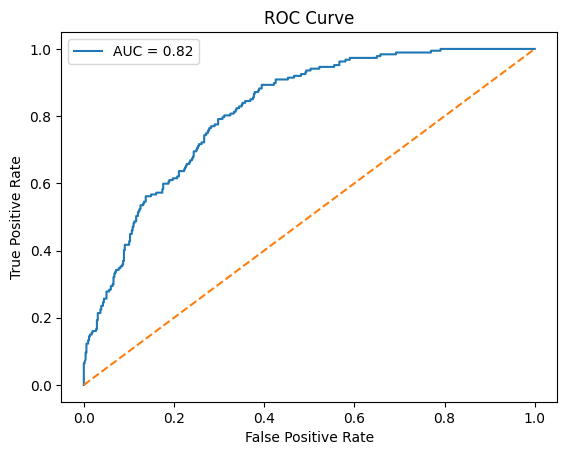

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# === Load and preprocess ===
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("→ Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✓ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Stratified split ===
df_train, df_test = train_test_split(df_clean, test_size=0.10, random_state=42, stratify=df_clean['Churn'])

# === Separate classes ===
minority_df = df_train[df_train['Churn'] == 1].copy()
majority_df = df_train[df_train['Churn'] == 0].copy()

# === Model definition ===
input_dim = df_train.shape[1] - 1
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Standardization ===
scaler = StandardScaler()
scaler.fit(df_train.drop('Churn', axis=1))

# === Phase 1: Train only on majority class ===
print("\n📘 Phase 1: Training on majority class only")
X_majority = scaler.transform(majority_df.drop('Churn', axis=1))
y_majority = majority_df['Churn'].values

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    model.fit(X_majority, y_majority, epochs=1, batch_size=64, verbose=0, shuffle=True)

# === Phase 2: Iteratively add minority samples ===
print("\n📗 Phase 2: Introducing minority samples in stages")

batch_sizes = [100, 200, 300, 400, 500]
for batch_size in batch_sizes:
    if batch_size > len(minority_df):
        batch = minority_df.copy()
    else:
        batch = minority_df.sample(n=batch_size, random_state=batch_size)

    combined_df = pd.concat([majority_df, batch])
    combined_df = combined_df.sample(frac=1, random_state=batch_size)  # Shuffle

    X_train_combined = scaler.transform(combined_df.drop('Churn', axis=1))
    y_train_combined = combined_df['Churn'].values

    print(f"\n🔁 Training with {batch.shape[0]} minority samples + {len(majority_df)} majority samples")
    for epoch in range(10):
        print(f"Epoch {epoch+1}/10")
        model.fit(X_train_combined, y_train_combined, epochs=1, batch_size=64, verbose=0, shuffle=True)

# === Evaluation ===
X_test = scaler.transform(df_test.drop('Churn', axis=1))
y_test = df_test['Churn'].values

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


→ Preprocessing data...
✓ Preprocessing complete.

📘 Phase 1: Training on majority class only
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10

📗 Phase 2: Iterating through batches of minority data

🔄 Processing batch size: 100
➡️ Training on minority batch 0–100 (size 100) + all majority (4646)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10
➡️ Training on minority batch 100–200 (size 100) + all majority (4646)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10
➡️ Training on minority batch 200–300 (size 100) + all majority (4646)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10
➡️ Training on minority batch 300–400 (size 100) + all majority (4646)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/1

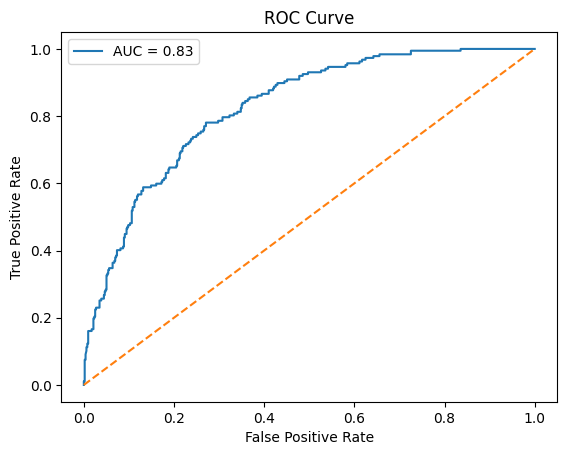

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# === Load and preprocess ===
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("→ Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✓ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Stratified split ===
df_train, df_test = train_test_split(df_clean, test_size=0.10, random_state=42, stratify=df_clean['Churn'])

# === Separate classes ===
minority_df = df_train[df_train['Churn'] == 1].copy()
majority_df = df_train[df_train['Churn'] == 0].copy()

# === Model definition ===
input_dim = df_train.shape[1] - 1
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Standardization ===
scaler = StandardScaler()
scaler.fit(df_train.drop('Churn', axis=1))

# === Phase 1: Train only on majority class ===
print("\n📘 Phase 1: Training on majority class only")
X_majority = scaler.transform(majority_df.drop('Churn', axis=1))
y_majority = majority_df['Churn'].values

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    model.fit(X_majority, y_majority, epochs=1, batch_size=64, verbose=0, shuffle=True)

# === Phase 2: Full minority coverage in batches (100 to 2000 step 100) ===
print("\n📗 Phase 2: Iterating through batches of minority data")

minority_total = len(minority_df)
batch_sizes = list(range(100, 2001, 100))

for batch_size in batch_sizes:
    print(f"\n🔄 Processing batch size: {batch_size}")

    # Create all batches of size batch_size from minority samples
    for start in range(0, minority_total, batch_size):
        end = min(start + batch_size, minority_total)
        minority_batch = minority_df.iloc[start:end]

        if len(minority_batch) == 0:
            continue  # skip empty

        combined_df = pd.concat([majority_df, minority_batch])
        combined_df = combined_df.sample(frac=1, random_state=start + batch_size)  # Shuffle

        X_train_combined = scaler.transform(combined_df.drop('Churn', axis=1))
        y_train_combined = combined_df['Churn'].values

        print(f"➡️ Training on minority batch {start}–{end} (size {len(minority_batch)}) + all majority ({len(majority_df)})")
        for epoch in range(10):
            print(f"   Epoch {epoch+1}/10")
            model.fit(X_train_combined, y_train_combined, epochs=1, batch_size=64, verbose=0, shuffle=True)

# === Evaluation ===
X_test = scaler.transform(df_test.drop('Churn', axis=1))
y_test = df_test['Churn'].values

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### same type of neural network, but it handles imbalance via oversampling churners to balance the training set before fitting.

→ Preprocessing data...
✓ Preprocessing complete.
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6785 - loss: 0.5987 - val_accuracy: 0.7762 - val_loss: 0.4854
Epoch 2/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7604 - loss: 0.5090 - val_accuracy: 0.7762 - val_loss: 0.4729
Epoch 3/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7577 - loss: 0.5000 - val_accuracy: 0.7768 - val_loss: 0.4713
Epoch 4/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7717 - loss: 0.4884 - val_accuracy: 0.7805 - val_loss: 0.4691
Epoch 5/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.4793 - val_accuracy: 0.7757 - val_loss: 0.4677
Epoch 6/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7885 - loss: 0.4707 - val_accuracy: 0.7816 - val_loss: 0.4680
Epoch 7/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - loss: 0.4783 - val_accuracy: 0.7768 - val_loss: 0.4642
Epoch 8/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.4807 - val_accuracy: 0.7784

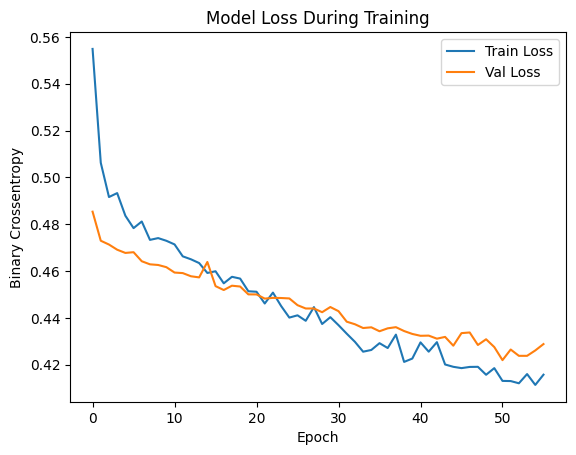

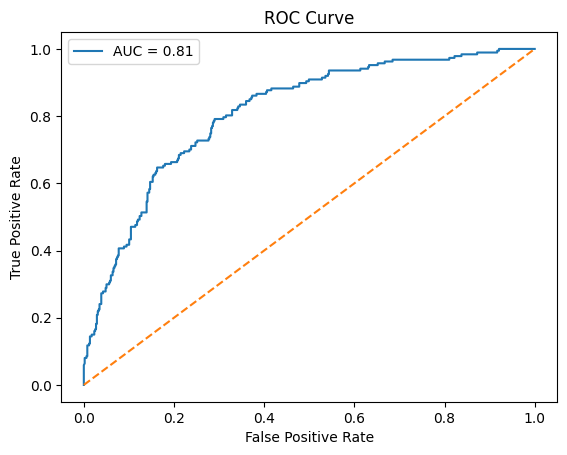

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === Load dataset ===
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

# === Preprocessing ===
def preprocess_data(df):
    print("→ Preprocessing data...")

    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()

    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    # Feature engineering
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])

    # One-hot encode categorical features
    df = pd.get_dummies(df, drop_first=True)

    print("✓ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Split: 90% train / 10% test ===
df_main, df_holdout = train_test_split(df_clean, test_size=0.10, random_state=42, stratify=df_clean['Churn'])

# === Separate majority and minority for oversampling ===
df_majority = df_main[df_main['Churn'] == 0]
df_minority = df_main[df_main['Churn'] == 1]

# === Oversample the minority class ===
df_minority_oversampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)

# === Combine and shuffle ===
df_balanced = pd.concat([df_majority, df_minority_oversampled]).sample(frac=1, random_state=42)

# === Split into features and labels ===
X_train = df_balanced.drop('Churn', axis=1)
y_train = df_balanced['Churn']
X_test = df_holdout.drop('Churn', axis=1)
y_test = df_holdout['Churn']

# === Normalize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Build the neural network ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Train the model ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# === Plot training history ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.show()

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### Training strategy (key difference)

Phase 1 → Train only on minority samples for 10 epochs → forces the model to learn churn patterns first.

Phase 2 → Iteratively introduce majority data in batches:

Batch sizes grow from 100 up to 2000 (step = 100).

For each batch, combine it with all minority samples and train for 10 epochs.

Ensures every stage includes all churners + a growing slice of non-churners.

→ Preprocessing data...
✓ Preprocessing complete.

📘 Phase 1: Training on minority class only
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10

📗 Phase 2: Iterating through batches of majority data

🔄 Processing batch size: 100
➡️ Training on majority batch 0–100 (size 100) + all minority (1682)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10
➡️ Training on majority batch 100–200 (size 100) + all minority (1682)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10
➡️ Training on majority batch 200–300 (size 100) + all minority (1682)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10
➡️ Training on majority batch 300–400 (size 100) + all minority (1682)
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/1

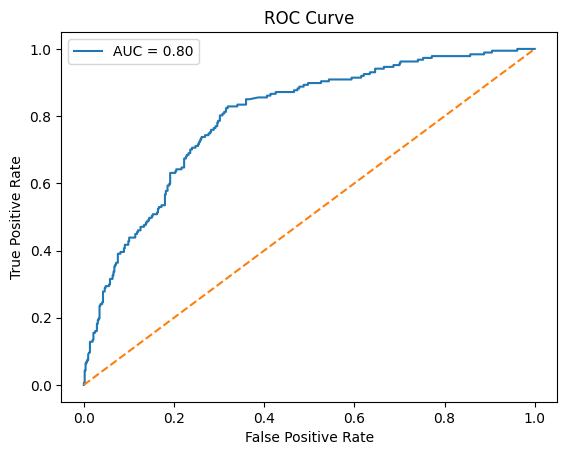

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# === Load and preprocess ===
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("→ Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✓ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Stratified split ===
df_train, df_test = train_test_split(df_clean, test_size=0.10, random_state=42, stratify=df_clean['Churn'])

# === Separate classes ===
minority_df = df_train[df_train['Churn'] == 1].copy()
majority_df = df_train[df_train['Churn'] == 0].copy()

# === Model definition ===
input_dim = df_train.shape[1] - 1
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Standardization ===
scaler = StandardScaler()
scaler.fit(df_train.drop('Churn', axis=1))

# === Phase 1: Train only on minority class ===
print("\n📘 Phase 1: Training on minority class only")
X_minority = scaler.transform(minority_df.drop('Churn', axis=1))
y_minority = minority_df['Churn'].values

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    model.fit(X_minority, y_minority, epochs=1, batch_size=64, verbose=0, shuffle=True)

# === Phase 2: Full majority coverage in batches (100 to 2000 step 100) ===
print("\n📗 Phase 2: Iterating through batches of majority data")

majority_total = len(majority_df)
batch_sizes = list(range(100, 2001, 100))

for batch_size in batch_sizes:
    print(f"\n🔄 Processing batch size: {batch_size}")

    # Create all batches of size batch_size from majority samples
    for start in range(0, majority_total, batch_size):
        end = min(start + batch_size, majority_total)
        majority_batch = majority_df.iloc[start:end]

        if len(majority_batch) == 0:
            continue  # skip empty

        combined_df = pd.concat([minority_df, majority_batch])
        combined_df = combined_df.sample(frac=1, random_state=start + batch_size)  # Shuffle

        X_train_combined = scaler.transform(combined_df.drop('Churn', axis=1))
        y_train_combined = combined_df['Churn'].values

        print(f"➡️ Training on majority batch {start}–{end} (size {len(majority_batch)}) + all minority ({len(minority_df)})")
        for epoch in range(10):
            print(f"   Epoch {epoch+1}/10")
            model.fit(X_train_combined, y_train_combined, epochs=1, batch_size=64, verbose=0, shuffle=True)

# === Evaluation ===
X_test = scaler.transform(df_test.drop('Churn', axis=1))
y_test = df_test['Churn'].values

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [1]:
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib torch-geometric -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 52.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 55.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.2 MB/s eta 0:00:00:00:01


## Marker

# standard clusterGCN

🔄 Loading dataset...
🧹 Preprocessing data...
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4646
1    3364
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🛠️ Building GCN model...
🧠 RAM used: 6.2%
🏋️ Training starts (full graph)...
📈 Epoch 001 | Loss: 0.9922 | Train Acc: 0.4826
📈 Epoch 002 | Loss: 0.7415 | Train Acc: 0.5969
📈 Epoch 003 | Loss: 0.6255 | Train Acc: 0.6770
📈 Epoch 004 | Loss: 0.5813 | Train Acc: 0.7134
📈 Epoch 005 | Loss: 0.5704 | Train Acc: 0.7260
📈 Epoch 006 | Loss: 0.5548 | Train Acc: 0.7423
📈 Epoch 007 | Loss: 0.5493 | Train Acc: 0.7486
📈 Epoch 008 | Loss: 0.5357 | Train Acc: 0.7522
📈 Epoch 009 | Loss: 0.5374 | Train Acc: 0.7537
📈 Epoch 010 | Loss: 0.5341 | Train Acc: 0.7573
📈 Epoch 011 | Loss: 0.5327 | Train Acc: 0.7556
📈 Ep

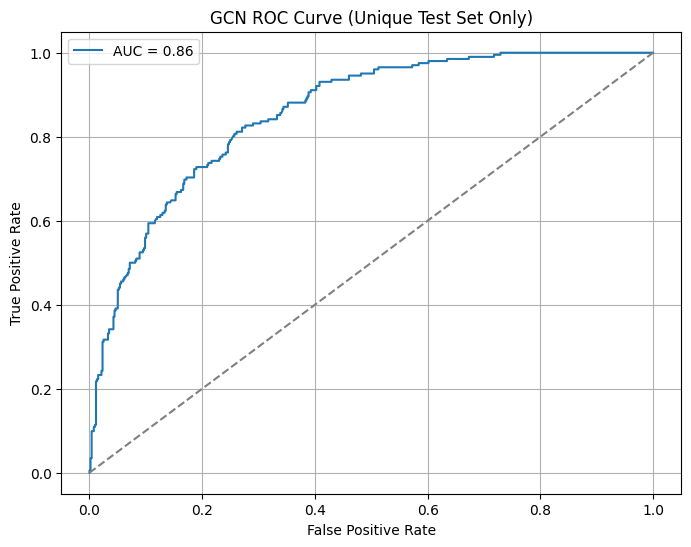

In [11]:
# ============================== #
#      Standard GCN Version      #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 2.0), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0)
df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0)
df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define standard GCN model ===
print("🛠️ Building GCN model...")
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training (full graph) ===
print("🏋️ Training starts (full graph)...")
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = out[data.train_mask].argmax(dim=1)
    acc = (pred == data.y[data.train_mask]).float().mean().item()
    print(f"📈 Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    # Extract only unique rows in df_holdout_original
    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)

    # Normalize and align with current graph
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)
    df_all_scaled['node_idx'] = df_all_scaled.index

    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("GCN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### GAT Version

🔄 Loading dataset...
🧹 Preprocessing data...
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4646
1    3364
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🛠️ Building GAT model...
🧠 RAM used: 6.2%
🏋️ Training starts (full graph)...
📈 Epoch 001 | Loss: 0.9613 | Train Acc: 0.5779
📈 Epoch 002 | Loss: 0.8371 | Train Acc: 0.6292
📈 Epoch 003 | Loss: 0.7847 | Train Acc: 0.6586
📈 Epoch 004 | Loss: 0.7620 | Train Acc: 0.6810
📈 Epoch 005 | Loss: 0.7390 | Train Acc: 0.6970
📈 Epoch 006 | Loss: 0.7301 | Train Acc: 0.7009
📈 Epoch 007 | Loss: 0.7023 | Train Acc: 0.7195
📈 Epoch 008 | Loss: 0.6945 | Train Acc: 0.7140
📈 Epoch 009 | Loss: 0.7071 | Train Acc: 0.7165
📈 Epoch 010 | Loss: 0.6810 | Train Acc: 0.7164
📈 Epoch 011 | Loss: 0.6488 | Train Acc: 0.7212
📈 Ep

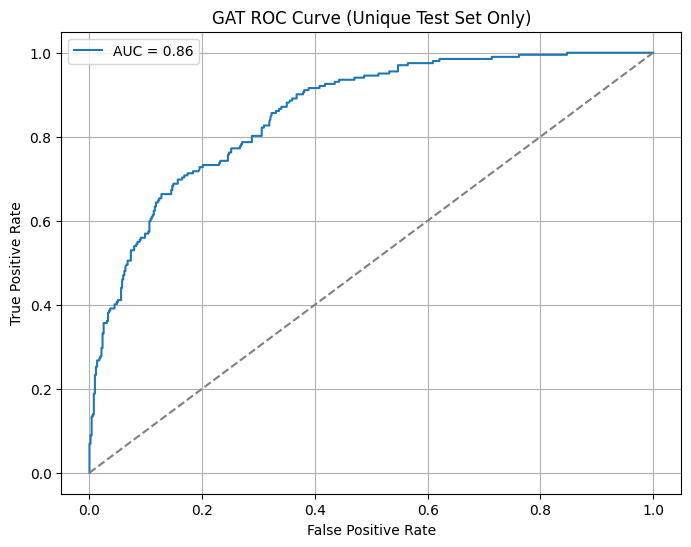

In [18]:
# ============================== #
#      GAT Attention Version     #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 2.0), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0)
df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0)
df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define GAT model ===
print("🛠️ Building GAT model...")
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training (full graph) ===
print("🏋️ Training starts (full graph)...")
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = out[data.train_mask].argmax(dim=1)
    acc = (pred == data.y[data.train_mask]).float().mean().item()
    print(f"📈 Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    # Extract only unique rows in df_holdout_original
    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)

    # Normalize and align with current graph
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)
    df_all_scaled['node_idx'] = df_all_scaled.index

    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("GAT ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### clusterGCN version

🔄 Loading dataset...
🧹 Preprocessing data...
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    6969
1    6728
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🛠️ Building ClusterGCN model...
📦 Partitioning graph...


Computing METIS partitioning...
Done!


🧠 RAM used: 6.2%
🏋️ Training starts...
📈 Epoch 001 | Loss: 1.0747 | Train Acc: 0.5626
📈 Epoch 002 | Loss: 0.7690 | Train Acc: 0.6355
📈 Epoch 003 | Loss: 0.6937 | Train Acc: 0.6797
📈 Epoch 004 | Loss: 0.6672 | Train Acc: 0.7147
📈 Epoch 005 | Loss: 0.6309 | Train Acc: 0.7346
📈 Epoch 006 | Loss: 0.6348 | Train Acc: 0.7419
📈 Epoch 007 | Loss: 0.6136 | Train Acc: 0.7513
📈 Epoch 008 | Loss: 0.5903 | Train Acc: 0.7545
📈 Epoch 009 | Loss: 0.5688 | Train Acc: 0.7537
📈 Epoch 010 | Loss: 0.5462 | Train Acc: 0.7491
📈 Epoch 011 | Loss: 0.5466 | Train Acc: 0.7495
📈 Epoch 012 | Loss: 0.5413 | Train Acc: 0.7401
📈 Epoch 013 | Loss: 0.5352 | Train Acc: 0.7362
📈 Epoch 014 | Loss: 0.5209 | Train Acc: 0.7421
📈 Epoch 015 | Loss: 0.5293 | Train Acc: 0.7392
📈 Epoch 016 | Loss: 0.5204 | Train Acc: 0.7439
📈 Epoch 017 | Loss: 0.5157 | Train Acc: 0.7510
📈 Epoch 018 | Loss: 0.5086 | Train Acc: 0.7517
📈 Epoch 019 | Loss: 0.5064 | Train Acc: 0.7548
📈 Epoch 020 | Loss: 0.5036 | Train Acc: 0.7575
📈 Epoch 021 | Loss: 0

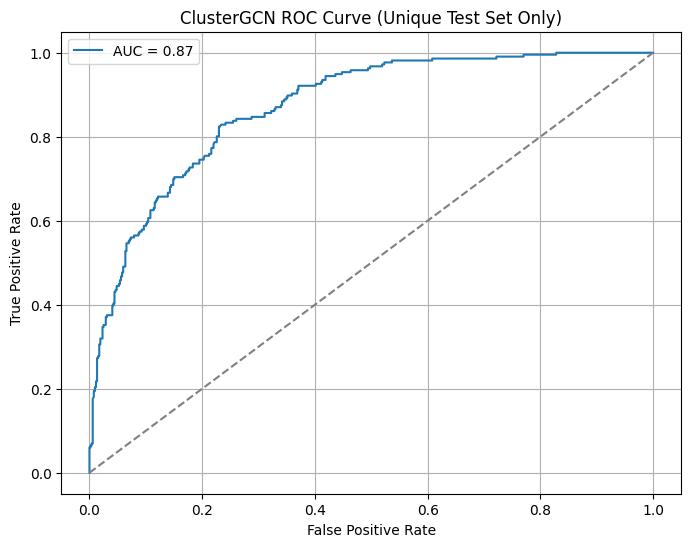

In [12]:
# ============================== #
#    Optimized Cluster-GCN      #
#    (Memory-Efficient Version) #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from torch_geometric.nn import ClusterGCNConv
from torch_geometric.loader import ClusterData, ClusterLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.5), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 4), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0)
df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0)
df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define model ===
print("🛠️ Building ClusterGCN model...")
class ClusterGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = ClusterGCNConv(in_channels, hidden_channels)
        self.conv2 = ClusterGCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# === ClusterLoader ===
print("📦 Partitioning graph...")
cluster_data = ClusterData(data, num_parts=10, recursive=False)
train_loader = ClusterLoader(cluster_data, batch_size=10, shuffle=True)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClusterGCN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training ===
print("🏋️ Training starts...")
for epoch in range(1, 101):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out[batch.train_mask].argmax(dim=1)
        total_correct += (pred == batch.y[batch.train_mask]).sum().item()
        total += batch.train_mask.sum().item()

    acc = total_correct / total
    print(f"📈 Epoch {epoch:03d} | Loss: {total_loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples (not repeated ones)...")
model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))

    # Extract only unique rows in df_holdout_original
    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)

    # Normalize and align with current graph
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    # Match unique samples to node indices in df_combined
    mask_rows = df_combined.reset_index(drop=True).drop('Churn', axis=1)
    # Match unique test samples to node indices in df_combined
    mask_unique = []
    
    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)

    df_all_scaled['node_idx'] = df_all_scaled.index
    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    
    mask_unique = matched['node_idx'].tolist()



    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ClusterGCN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# Drop target column to compare raw features only
train_features = df_balanced.drop(columns=['Churn']).drop_duplicates()
test_features = df_holdout_original.drop(columns=['Churn']).drop_duplicates()

# Convert to tuples for set operations
train_set = set(map(tuple, train_features.values))
test_set = set(map(tuple, test_features.values))

# Compute counts
unique_train_count = len(train_set)
unique_test_count = len(test_set)
common_count = len(train_set & test_set)

print(f"🔢 Unique samples in train set: {unique_train_count}")
print(f"🔢 Unique samples in test set: {unique_test_count}")
print(f"🔁 Common samples in both: {common_count}")


🔢 Unique samples in train set: 5220
🔢 Unique samples in test set: 701
🔁 Common samples in both: 7


### from here onwards custom cluster wise GNN

### ClusterGAN K2

🔄 Loading dataset...
🧹 Preprocessing data...
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4646
1    3364
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🧠 RAM used: 4.8%
🏋️ Training starts (per-cluster)...
📈 Epoch 001 | Loss: 1.5785 | Train Acc: 0.5085
📈 Epoch 002 | Loss: 1.1861 | Train Acc: 0.6699
📈 Epoch 003 | Loss: 1.0964 | Train Acc: 0.7207
📈 Epoch 004 | Loss: 1.0784 | Train Acc: 0.7390
📈 Epoch 005 | Loss: 1.0478 | Train Acc: 0.7407
📈 Epoch 006 | Loss: 1.0102 | Train Acc: 0.7501
📈 Epoch 007 | Loss: 1.0066 | Train Acc: 0.7531
📈 Epoch 008 | Loss: 0.9973 | Train Acc: 0.7538
📈 Epoch 009 | Loss: 0.9822 | Train Acc: 0.7582
📈 Epoch 010 | Loss: 0.9839 | Train Acc: 0.7561
📈 Epoch 011 | Loss: 0.9760 | Train Acc: 0.7568
📈 Epoch 012 | Loss: 0.9739 |

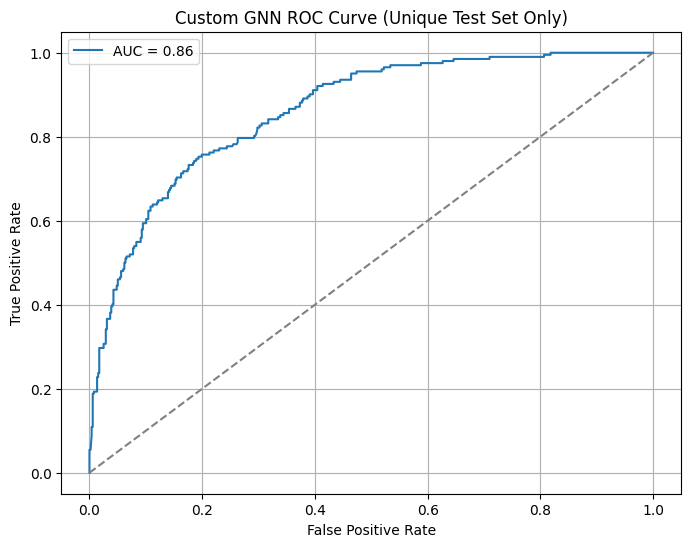

In [18]:
# ============================== #
#    Custom Cluster-Wise GNN    #
#   Using Predefined Clusters   #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/churn-clustered-datasets/Churn7043_clusterGAN_cluster_data_K2.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Separate cluster column before upsampling ===
clusters = df['Cluster'].copy()  # Use original df to match indices
df_clean = df_clean.reset_index(drop=True)
clusters = clusters.reset_index(drop=True)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
clusters = clusters.loc[df_clean.index].reset_index(drop=True)

df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)
clusters_main = clusters.loc[df_main.index].reset_index(drop=True)
clusters_holdout = clusters.loc[df_holdout_original.index].reset_index(drop=True)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 2.0), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# Restore cluster column for upsampled data using a merge instead of index-based lookup
df_main_with_clusters = df_main.copy()
df_main_with_clusters['Cluster'] = clusters_main

churn_0_upsampled = churn_0_upsampled.merge(churn_0.merge(df_main_with_clusters, how='left'), how='left')
churn_1_upsampled = churn_1_upsampled.merge(churn_1.merge(df_main_with_clusters, how='left'), how='left')

clusters_balanced = pd.concat([
    churn_0_upsampled['Cluster'],
    churn_1_upsampled['Cluster']
], axis=0).reset_index(drop=True)

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0).reset_index(drop=True)
clusters_combined = pd.concat([clusters_balanced, clusters_holdout], axis=0).reset_index(drop=True)

df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)
clusters_combined = clusters_combined.loc[df_combined.index].reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define custom GCN model ===
class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().unsqueeze(1).clamp(min=1)
        agg = torch.zeros_like(x).scatter_add_(0, row.unsqueeze(1).expand(-1, x.size(1)), x[col])
        x = x + agg / deg
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGNN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training per cluster ===
print("🏋️ Training starts (per-cluster)...")
data = data.to(device)
clusters_tensor = torch.tensor(clusters_combined.values, dtype=torch.long)

for epoch in range(1, 101):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for cluster_id in torch.unique(clusters_tensor):
        mask = (clusters_tensor == cluster_id) & data.train_mask
        if mask.sum() == 0:
            continue

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out[mask].argmax(dim=1)
        total_correct += (pred == data.y[mask]).sum().item()
        total += mask.sum().item()

    acc = total_correct / total if total > 0 else 0
    print(f"📈 Epoch {epoch:03d} | Loss: {total_loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples (not repeated ones)...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)

    df_all_scaled['node_idx'] = df_all_scaled.index
    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Custom GNN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### LCA K5

🔄 Loading dataset...
🧹 Preprocessing data...
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4646
1    3279
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🧠 RAM used: 4.9%
🏋️ Training starts (per-cluster)...
📈 Epoch 001 | Loss: 3.3564 | Train Acc: 0.6076
📈 Epoch 002 | Loss: 2.6537 | Train Acc: 0.7471
📈 Epoch 003 | Loss: 2.5382 | Train Acc: 0.7624
📈 Epoch 004 | Loss: 2.4385 | Train Acc: 0.7709
📈 Epoch 005 | Loss: 2.3856 | Train Acc: 0.7726
📈 Epoch 006 | Loss: 2.3586 | Train Acc: 0.7791
📈 Epoch 007 | Loss: 2.3276 | Train Acc: 0.7823
📈 Epoch 008 | Loss: 2.3051 | Train Acc: 0.7860
📈 Epoch 009 | Loss: 2.3043 | Train Acc: 0.7791
📈 Epoch 010 | Loss: 2.2924 | Train Acc: 0.7833
📈 Epoch 011 | Loss: 2.2905 | Train Acc: 0.7851
📈 Epoch 012 | Loss: 2.2973 |

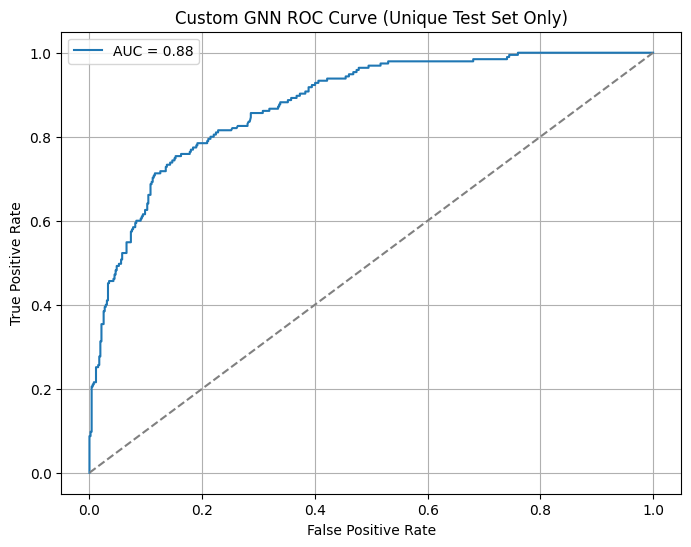

In [31]:
# ============================== #
#    Custom Cluster-Wise GNN    #
#   Using Predefined Clusters   #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/churn-clustered-datasets/clustered_LCA_K5.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Separate cluster column before upsampling ===
clusters = df['Cluster'].copy()  # Use original df to match indices
df_clean = df_clean.reset_index(drop=True)
clusters = clusters.reset_index(drop=True)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
clusters = clusters.loc[df_clean.index].reset_index(drop=True)

df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)
clusters_main = clusters.loc[df_main.index].reset_index(drop=True)
clusters_holdout = clusters.loc[df_holdout_original.index].reset_index(drop=True)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 1.95), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# Restore cluster column for upsampled data using a merge instead of index-based lookup
df_main_with_clusters = df_main.copy()
df_main_with_clusters['Cluster'] = clusters_main

churn_0_upsampled = churn_0_upsampled.merge(churn_0.merge(df_main_with_clusters, how='left'), how='left')
churn_1_upsampled = churn_1_upsampled.merge(churn_1.merge(df_main_with_clusters, how='left'), how='left')

clusters_balanced = pd.concat([
    churn_0_upsampled['Cluster'],
    churn_1_upsampled['Cluster']
], axis=0).reset_index(drop=True)

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0).reset_index(drop=True)
clusters_combined = pd.concat([clusters_balanced, clusters_holdout], axis=0).reset_index(drop=True)

df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)
clusters_combined = clusters_combined.loc[df_combined.index].reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define custom GCN model ===
class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().unsqueeze(1).clamp(min=1)
        agg = torch.zeros_like(x).scatter_add_(0, row.unsqueeze(1).expand(-1, x.size(1)), x[col])
        x = x + agg / deg
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGNN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training per cluster ===
print("🏋️ Training starts (per-cluster)...")
data = data.to(device)
clusters_tensor = torch.tensor(clusters_combined.values, dtype=torch.long)

for epoch in range(1, 101):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for cluster_id in torch.unique(clusters_tensor):
        mask = (clusters_tensor == cluster_id) & data.train_mask
        if mask.sum() == 0:
            continue

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out[mask].argmax(dim=1)
        total_correct += (pred == data.y[mask]).sum().item()
        total += mask.sum().item()

    acc = total_correct / total if total > 0 else 0
    print(f"📈 Epoch {epoch:03d} | Loss: {total_loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples (not repeated ones)...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)

    df_all_scaled['node_idx'] = df_all_scaled.index
    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Custom GNN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### Gower_hierarchical_k4

🔄 Loading dataset...
🧹 Preprocessing data...
🧪 Churn values before mapping: [0 1]
🧪 Churn values after mapping (if applied): [0 1]
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4656
1    2354
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🧠 RAM used: 4.8%
🏋️ Training starts (per-cluster)...
📈 Epoch 001 | Loss: 2.9836 | Train Acc: 0.5542
📈 Epoch 002 | Loss: 2.2227 | Train Acc: 0.7103
📈 Epoch 003 | Loss: 2.0841 | Train Acc: 0.7337
📈 Epoch 004 | Loss: 2.0134 | Train Acc: 0.7489
📈 Epoch 005 | Loss: 1.9505 | Train Acc: 0.7555
📈 Epoch 006 | Loss: 1.9433 | Train Acc: 0.7535
📈 Epoch 007 | Loss: 1.9065 | Train Acc: 0.7582
📈 Epoch 008 | Loss: 1.9055 | Train Acc: 0.7616
📈 Epoch 009 | Loss: 1.8976 | Train Acc: 0.7608
📈 Epoch 010 | Loss: 1.8758 | Train A

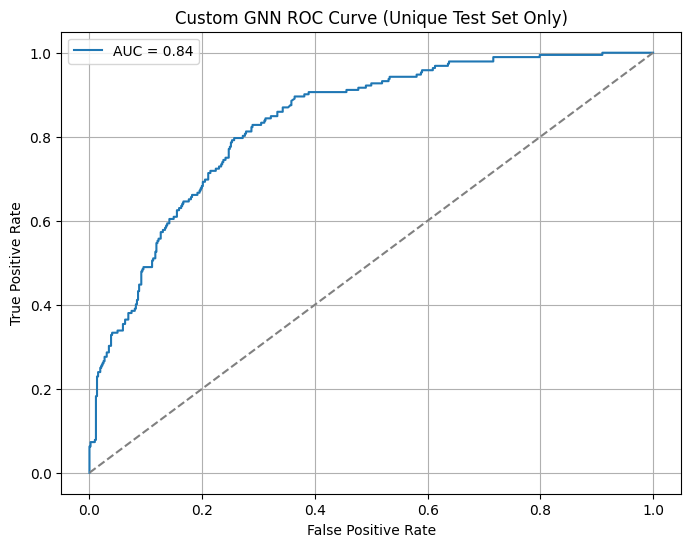

In [46]:
# ============================== #
#    Custom Cluster-Wise GNN    #
#   Using Predefined Clusters   #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/churn-clustered-datasets/clustered_gower_hierarchical_k4.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna(subset=['TotalCharges'])  # Remove invalid TotalCharges

    print("🧪 Churn values before mapping:", df['Churn'].unique())
    # Only map if Churn is not already numeric
    if df['Churn'].dtype == object:
        df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    
    # Remove any resulting NaNs in Churn
    df = df.dropna(subset=['Churn'])
    df['Churn'] = df['Churn'].astype(int)

    print("🧪 Churn values after mapping (if applied):", df['Churn'].unique())

    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Separate cluster column before upsampling ===
clusters = df['Cluster'].copy()  # Use original df to match indices
df_clean = df_clean.reset_index(drop=True)
clusters = clusters.reset_index(drop=True)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
clusters = clusters.loc[df_clean.index].reset_index(drop=True)

df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)
clusters_main = clusters.loc[df_main.index].reset_index(drop=True)
clusters_holdout = clusters.loc[df_holdout_original.index].reset_index(drop=True)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 1.4), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# Restore cluster column for upsampled data using a merge instead of index-based lookup
df_main_with_clusters = df_main.copy()
df_main_with_clusters['Cluster'] = clusters_main

churn_0_upsampled = churn_0_upsampled.merge(churn_0.merge(df_main_with_clusters, how='left'), how='left')
churn_1_upsampled = churn_1_upsampled.merge(churn_1.merge(df_main_with_clusters, how='left'), how='left')

clusters_balanced = pd.concat([
    churn_0_upsampled['Cluster'],
    churn_1_upsampled['Cluster']
], axis=0).reset_index(drop=True)

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0).reset_index(drop=True)
clusters_combined = pd.concat([clusters_balanced, clusters_holdout], axis=0).reset_index(drop=True)

df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)
clusters_combined = clusters_combined.loc[df_combined.index].reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define custom GCN model ===
class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().unsqueeze(1).clamp(min=1)
        agg = torch.zeros_like(x).scatter_add_(0, row.unsqueeze(1).expand(-1, x.size(1)), x[col])
        x = x + agg / deg
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGNN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training per cluster ===
print("🏋️ Training starts (per-cluster)...")
data = data.to(device)
clusters_tensor = torch.tensor(clusters_combined.values, dtype=torch.long)

for epoch in range(1, 101):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for cluster_id in torch.unique(clusters_tensor):
        mask = (clusters_tensor == cluster_id) & data.train_mask
        if mask.sum() == 0:
            continue

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out[mask].argmax(dim=1)
        total_correct += (pred == data.y[mask]).sum().item()
        total += mask.sum().item()

    acc = total_correct / total if total > 0 else 0
    print(f"📈 Epoch {epoch:03d} | Loss: {total_loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples (not repeated ones)...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)

    df_all_scaled['node_idx'] = df_all_scaled.index
    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Custom GNN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### kprototype_k20

🔄 Loading dataset...
🧹 Preprocessing data...
🧪 Churn values before mapping: [0 1]
🧪 Churn values after mapping (if applied): [0 1]
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4656
1    2354
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🧠 RAM used: 4.7%
🏋️ Training starts (per-cluster)...
📈 Epoch 001 | Loss: 10.8695 | Train Acc: 0.7061
📈 Epoch 002 | Loss: 9.6646 | Train Acc: 0.7502
📈 Epoch 003 | Loss: 9.3996 | Train Acc: 0.7693
📈 Epoch 004 | Loss: 9.3293 | Train Acc: 0.7723
📈 Epoch 005 | Loss: 9.3211 | Train Acc: 0.7663
📈 Epoch 006 | Loss: 9.2313 | Train Acc: 0.7700
📈 Epoch 007 | Loss: 9.1631 | Train Acc: 0.7732
📈 Epoch 008 | Loss: 9.1189 | Train Acc: 0.7776
📈 Epoch 009 | Loss: 9.0900 | Train Acc: 0.7759
📈 Epoch 010 | Loss: 9.0766 | Train 

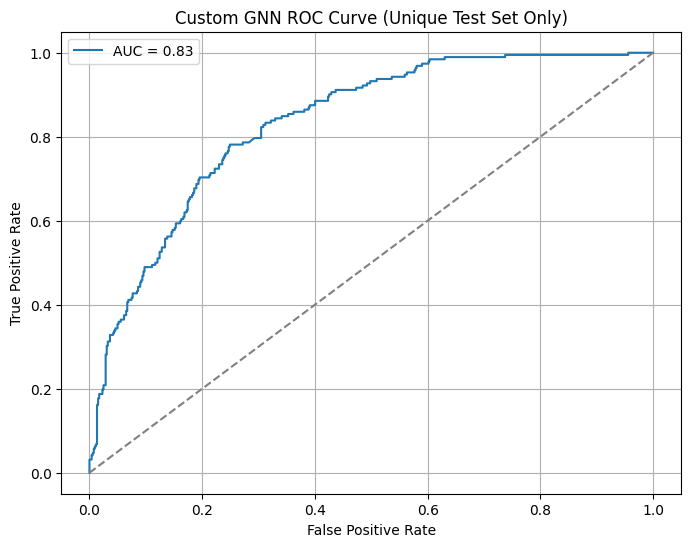

In [50]:
# ============================== #
#    Custom Cluster-Wise GNN    #
#   Using Predefined Clusters   #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/churn-clustered-datasets/clustered_churn_kprototype_k20.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna(subset=['TotalCharges'])  # Remove invalid TotalCharges

    print("🧪 Churn values before mapping:", df['Churn'].unique())
    # Only map if Churn is not already numeric
    if df['Churn'].dtype == object:
        df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    
    # Remove any resulting NaNs in Churn
    df = df.dropna(subset=['Churn'])
    df['Churn'] = df['Churn'].astype(int)

    print("🧪 Churn values after mapping (if applied):", df['Churn'].unique())

    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Separate cluster column before upsampling ===
clusters = df['Cluster'].copy()  # Use original df to match indices
df_clean = df_clean.reset_index(drop=True)
clusters = clusters.reset_index(drop=True)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
clusters = clusters.loc[df_clean.index].reset_index(drop=True)

df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)
clusters_main = clusters.loc[df_main.index].reset_index(drop=True)
clusters_holdout = clusters.loc[df_holdout_original.index].reset_index(drop=True)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 1.4), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# Restore cluster column for upsampled data using a merge instead of index-based lookup
df_main_with_clusters = df_main.copy()
df_main_with_clusters['Cluster'] = clusters_main

churn_0_upsampled = churn_0_upsampled.merge(churn_0.merge(df_main_with_clusters, how='left'), how='left')
churn_1_upsampled = churn_1_upsampled.merge(churn_1.merge(df_main_with_clusters, how='left'), how='left')

clusters_balanced = pd.concat([
    churn_0_upsampled['Cluster'],
    churn_1_upsampled['Cluster']
], axis=0).reset_index(drop=True)

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0).reset_index(drop=True)
clusters_combined = pd.concat([clusters_balanced, clusters_holdout], axis=0).reset_index(drop=True)

df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)
clusters_combined = clusters_combined.loc[df_combined.index].reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define custom GCN model ===
class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().unsqueeze(1).clamp(min=1)
        agg = torch.zeros_like(x).scatter_add_(0, row.unsqueeze(1).expand(-1, x.size(1)), x[col])
        x = x + agg / deg
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGNN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training per cluster ===
print("🏋️ Training starts (per-cluster)...")
data = data.to(device)
clusters_tensor = torch.tensor(clusters_combined.values, dtype=torch.long)

for epoch in range(1, 101):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for cluster_id in torch.unique(clusters_tensor):
        mask = (clusters_tensor == cluster_id) & data.train_mask
        if mask.sum() == 0:
            continue

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out[mask].argmax(dim=1)
        total_correct += (pred == data.y[mask]).sum().item()
        total += mask.sum().item()

    acc = total_correct / total if total > 0 else 0
    print(f"📈 Epoch {epoch:03d} | Loss: {total_loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples (not repeated ones)...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)

    df_all_scaled['node_idx'] = df_all_scaled.index
    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Custom GNN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### kprototype_k8

🔄 Loading dataset...
🧹 Preprocessing data...
🧪 Churn values before mapping: [0 1]
🧪 Churn values after mapping (if applied): [0 1]
✅ Preprocessing complete.
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4656
1    2102
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🧠 RAM used: 5.2%
🏋️ Training starts (per-cluster)...
📈 Epoch 001 | Loss: 5.1476 | Train Acc: 0.6301
📈 Epoch 002 | Loss: 4.0831 | Train Acc: 0.7564
📈 Epoch 003 | Loss: 3.8150 | Train Acc: 0.7652
📈 Epoch 004 | Loss: 3.7107 | Train Acc: 0.7745
📈 Epoch 005 | Loss: 3.6855 | Train Acc: 0.7749
📈 Epoch 006 | Loss: 3.5875 | Train Acc: 0.7795
📈 Epoch 007 | Loss: 3.5790 | Train Acc: 0.7780
📈 Epoch 008 | Loss: 3.5738 | Train Acc: 0.7841
📈 Epoch 009 | Loss: 3.5589 | Train Acc: 0.7859
📈 Epoch 010 | Loss: 3.5344 | Train A

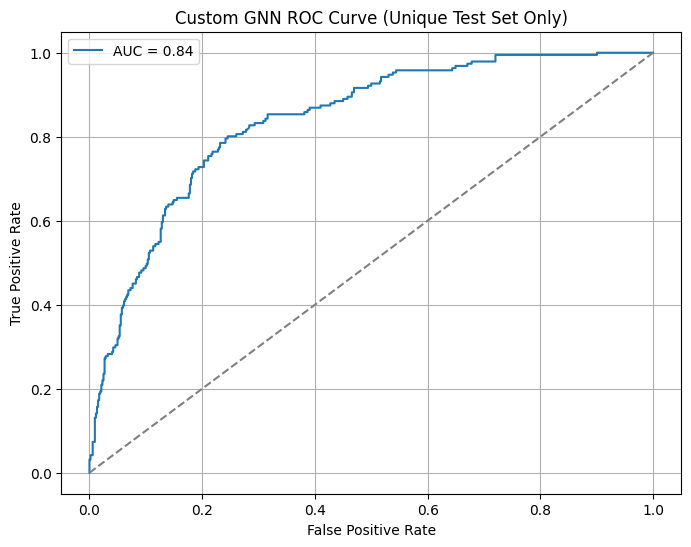

In [3]:
# ============================== #
#    Custom Cluster-Wise GNN    #
#   Using Predefined Clusters   #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/churn-clustered-datasets/clustered_churn_kprototype_k8.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna(subset=['TotalCharges'])  # Remove invalid TotalCharges

    print("🧪 Churn values before mapping:", df['Churn'].unique())
    # Only map if Churn is not already numeric
    if df['Churn'].dtype == object:
        df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    
    # Remove any resulting NaNs in Churn
    df = df.dropna(subset=['Churn'])
    df['Churn'] = df['Churn'].astype(int)

    print("🧪 Churn values after mapping (if applied):", df['Churn'].unique())

    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])
    df = pd.get_dummies(df, drop_first=True)
    print("✅ Preprocessing complete.")
    return df

df_clean = preprocess_data(df)

# === Separate cluster column before upsampling ===
clusters = df['Cluster'].copy()  # Use original df to match indices
df_clean = df_clean.reset_index(drop=True)
clusters = clusters.reset_index(drop=True)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
clusters = clusters.loc[df_clean.index].reset_index(drop=True)

df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)
clusters_main = clusters.loc[df_main.index].reset_index(drop=True)
clusters_holdout = clusters.loc[df_holdout_original.index].reset_index(drop=True)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 1.25), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# Restore cluster column for upsampled data using a merge instead of index-based lookup
df_main_with_clusters = df_main.copy()
df_main_with_clusters['Cluster'] = clusters_main

churn_0_upsampled = churn_0_upsampled.merge(churn_0.merge(df_main_with_clusters, how='left'), how='left')
churn_1_upsampled = churn_1_upsampled.merge(churn_1.merge(df_main_with_clusters, how='left'), how='left')

clusters_balanced = pd.concat([
    churn_0_upsampled['Cluster'],
    churn_1_upsampled['Cluster']
], axis=0).reset_index(drop=True)

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0).reset_index(drop=True)
clusters_combined = pd.concat([clusters_balanced, clusters_holdout], axis=0).reset_index(drop=True)

df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)
clusters_combined = clusters_combined.loc[df_combined.index].reset_index(drop=True)

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define custom GCN model ===
class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().unsqueeze(1).clamp(min=1)
        agg = torch.zeros_like(x).scatter_add_(0, row.unsqueeze(1).expand(-1, x.size(1)), x[col])
        x = x + agg / deg
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGNN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training per cluster ===
print("🏋️ Training starts (per-cluster)...")
data = data.to(device)
clusters_tensor = torch.tensor(clusters_combined.values, dtype=torch.long)

for epoch in range(1, 101):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for cluster_id in torch.unique(clusters_tensor):
        mask = (clusters_tensor == cluster_id) & data.train_mask
        if mask.sum() == 0:
            continue

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out[mask].argmax(dim=1)
        total_correct += (pred == data.y[mask]).sum().item()
        total += mask.sum().item()

    acc = total_correct / total if total > 0 else 0
    print(f"📈 Epoch {epoch:03d} | Loss: {total_loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples (not repeated ones)...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)

    df_all_scaled['node_idx'] = df_all_scaled.index
    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Custom GNN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### clusterGAN_4clusters

🔄 Loading dataset...
🧹 Preprocessing data...
🧪 Churn values before mapping: [0 1]
🧪 Churn values after mapping (if applied): [0 1]
✅ Preprocessing complete. Any NaNs left?: 0
📦 Holding out clean, original 10% test set (pre-upsampling)...
🔁 Upsampling training data only...
✅ Class distribution after upsampling:
Churn
0    4145
1    2253
Name: count, dtype: int64
🧩 Combining training and original test set for graph...
📏 Normalizing features...
🧠 Constructing k-NN graph...
🎭 Creating train/test masks...
🧠 RAM used: 5.8%
🏋️ Training starts (per-cluster)...
📈 Epoch 001 | Loss: 2.5627 | Train Acc: 0.6282
📈 Epoch 002 | Loss: 2.1135 | Train Acc: 0.7346
📈 Epoch 003 | Loss: 2.0310 | Train Acc: 0.7488
📈 Epoch 004 | Loss: 2.0128 | Train Acc: 0.7507
📈 Epoch 005 | Loss: 1.9730 | Train Acc: 0.7530
📈 Epoch 006 | Loss: 1.9498 | Train Acc: 0.7590
📈 Epoch 007 | Loss: 1.9380 | Train Acc: 0.7646
📈 Epoch 008 | Loss: 1.9035 | Train Acc: 0.7706
📈 Epoch 009 | Loss: 1.8941 | Train Acc: 0.7710
📈 Epoch 010 | Loss

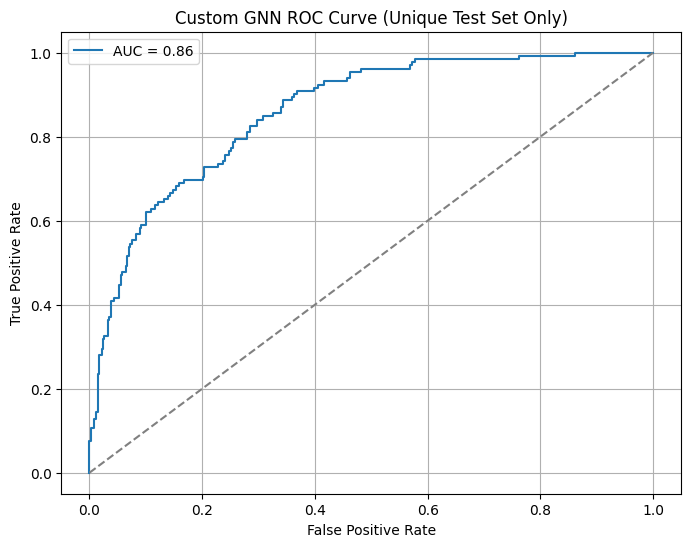

In [25]:
# ============================== #
#    Custom Cluster-Wise GNN    #
#   Using Predefined Clusters   #
# ============================== #

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc
import psutil

from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph

# === Load and preprocess data ===
print("🔄 Loading dataset...")
df = pd.read_csv('/kaggle/input/churn-clustered-datasets/Churn7043_clusterGAN_4clusters.csv')

def preprocess_data(df):
    print("🧹 Preprocessing data...")
    df = df.drop(columns=['customerID'], errors='ignore')
    
    # Convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Drop rows where TotalCharges is NaN
    df = df.dropna(subset=['TotalCharges'])

    # Map Churn if necessary
    print("🧪 Churn values before mapping:", df['Churn'].unique())
    if df['Churn'].dtype == object:
        df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    
    df = df.dropna(subset=['Churn'])
    df['Churn'] = df['Churn'].astype(int)
    print("🧪 Churn values after mapping (if applied):", df['Churn'].unique())

    # Add log TotalCharges
    df['TotalCharges_log'] = np.log1p(df['TotalCharges'])

    # Convert categorical to dummies
    df = pd.get_dummies(df, drop_first=True)

    # Drop rows with any remaining NaNs
    df = df.dropna()
    
    print("✅ Preprocessing complete. Any NaNs left?:", df.isna().sum().sum())
    return df

df_clean = preprocess_data(df)

# === Separate cluster column before upsampling ===
clusters = df['Cluster'].copy()  # Use original df to match indices
df_clean = df_clean.reset_index(drop=True)
clusters = clusters.reset_index(drop=True)

# === Hold out test set BEFORE upsampling ===
print("📦 Holding out clean, original 10% test set (pre-upsampling)...")
df_clean = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
clusters = clusters.loc[df_clean.index].reset_index(drop=True)

df_main, df_holdout_original = train_test_split(df_clean, test_size=0.10, stratify=df_clean['Churn'], random_state=42)
clusters_main = clusters.loc[df_main.index].reset_index(drop=True)
clusters_holdout = clusters.loc[df_holdout_original.index].reset_index(drop=True)

# === Upsample df_main ===
print("🔁 Upsampling training data only...")
churn_0 = df_main[df_main['Churn'] == 0]
churn_1 = df_main[df_main['Churn'] == 1]

churn_0_upsampled = churn_0.sample(n=int(len(churn_0) * 1.0), replace=True, random_state=42)
churn_1_upsampled = churn_1.sample(n=int(len(churn_1) * 1.9), replace=True, random_state=42)

df_balanced = pd.concat([churn_0_upsampled, churn_1_upsampled], axis=0).reset_index(drop=True)
print(f"✅ Class distribution after upsampling:\n{df_balanced['Churn'].value_counts()}")

# Restore cluster column for upsampled data using a merge instead of index-based lookup
df_main_with_clusters = df_main.copy()
df_main_with_clusters['Cluster'] = clusters_main

churn_0_upsampled = churn_0_upsampled.merge(churn_0.merge(df_main_with_clusters, how='left'), how='left')
churn_1_upsampled = churn_1_upsampled.merge(churn_1.merge(df_main_with_clusters, how='left'), how='left')

clusters_balanced = pd.concat([
    churn_0_upsampled['Cluster'],
    churn_1_upsampled['Cluster']
], axis=0).reset_index(drop=True)

# === Combine for graph ===
print("🧩 Combining training and original test set for graph...")
df_combined = pd.concat([df_balanced, df_holdout_original], axis=0).reset_index(drop=True)
clusters_combined = pd.concat([clusters_balanced, clusters_holdout], axis=0).reset_index(drop=True)

# Final shuffle
df_combined = df_combined.sample(frac=1.0, random_state=99).reset_index(drop=True)
clusters_combined = clusters_combined.loc[df_combined.index].reset_index(drop=True)

# Check and drop NaNs before graph
df_combined = df_combined.dropna()

X_all = df_combined.drop('Churn', axis=1)
y_all = df_combined['Churn'].values

# Double check
if np.isnan(X_all.values).any():
    raise ValueError("❌ X_all still contains NaNs after preprocessing.")

# === Normalize ===
print("📏 Normalizing features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Graph construction ===
print("🧠 Constructing k-NN graph...")
knn_graph = kneighbors_graph(X_all_scaled, n_neighbors=4, mode='connectivity', include_self=False, n_jobs=-1)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

x = torch.tensor(X_all_scaled, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# === Masks ===
print("🎭 Creating train/test masks...")
num_nodes = data.num_nodes
train_size = len(df_balanced)
test_size = len(df_holdout_original)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, train_size + test_size)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# === Define custom GCN model ===
class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().unsqueeze(1).clamp(min=1)
        agg = torch.zeros_like(x).scatter_add_(0, row.unsqueeze(1).expand(-1, x.size(1)), x[col])
        x = x + agg / deg
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGNN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

gc.collect()
print(f"🧠 RAM used: {psutil.virtual_memory().percent}%")

# === Training per cluster ===
print("🏋️ Training starts (per-cluster)...")
data = data.to(device)
clusters_tensor = torch.tensor(clusters_combined.values, dtype=torch.long)

for epoch in range(1, 101):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for cluster_id in torch.unique(clusters_tensor):
        mask = (clusters_tensor == cluster_id) & data.train_mask
        if mask.sum() == 0:
            continue

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out[mask].argmax(dim=1)
        total_correct += (pred == data.y[mask]).sum().item()
        total += mask.sum().item()

    acc = total_correct / total if total > 0 else 0
    print(f"📈 Epoch {epoch:03d} | Loss: {total_loss:.4f} | Train Acc: {acc:.4f}")

# === Evaluation on UNIQUE test samples ===
print("🧪 Evaluating ONLY on unique test samples (not repeated ones)...")
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    df_holdout_unique = df_holdout_original.drop_duplicates().reset_index(drop=True)
    X_test_unique = scaler.transform(df_holdout_unique.drop('Churn', axis=1))
    y_test_unique = df_holdout_unique['Churn'].values

    df_all_scaled = pd.DataFrame(X_all_scaled)
    df_test_unique_scaled = pd.DataFrame(X_test_unique)

    df_all_scaled['node_idx'] = df_all_scaled.index
    matched = df_all_scaled.merge(df_test_unique_scaled.drop_duplicates(), how='inner')
    mask_unique = matched['node_idx'].tolist()

    unique_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    unique_test_mask[mask_unique] = True

    logits = out[unique_test_mask]
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y[unique_test_mask].cpu().numpy()
    y_proba = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# === Metrics ===
print("\n📊 Classification Report (Unique Test Set Only):")
print(classification_report(y_true, y_pred))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_true, y_proba))

# === ROC Curve ===
print("📉 Plotting ROC curve (Unique Test Set)...")
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Custom GNN ROC Curve (Unique Test Set Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
